In [ ]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
## load the training data
train_features = pd.read_csv('data/dengue_features_train.csv')
train_labels = pd.read_csv('data/dengue_labels_train.csv')
## merge features and labels
training_data = train_features.merge(train_labels, on=['city','year','weekofyear']).sort_values('week_start_date')
training_data['year'] = training_data['year'].astype(int)
training_data = training_data.set_index(['city','year','weekofyear'])

In [ ]:
training_data.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.337143   
          22                                     80.460000   

                      reanalysis_sat_precip_amt_mm  \
city year weekofyear                                 
sj   1990 18                                 12.42   
          19                                 22.82   
          20                                 34.54   
          21                                 15.36   
          22                                  7.52   

                      reanalysis_specific_humidity_g_per_kg  \
city year weekofyear                                          
sj   1990 18                                      14.012857   
          19                                      15.372857   
          20                                      16.848571   
          21                                      16.672857   
          22                                      17.210000   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city year weekofyear                                          
sj   1990 18                   2.628571           25.442857   
          19                   2.371429           26.714286   
          20                   2.300000           26.714286   
          21                   2.428571           27.471429   
          22                   3.014286           28.942857   

                      station_diur_temp_rng_c  station_max_temp_c  \
city year weekofyear                                                
sj   1990 18                         6.900000                29.4   
          19                         6.371429                31.7   
          20                         6.485714                32.2   
       

In [ ]:
## small and relatively balanaced dataset
train_features.reset_index()['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [ ]:
## Seperate training and validation data for San Juan
sj_train_features, sj_validation_dataset, sj_train_labels, sj_validation_labels = train_test_split(training_data.loc['sj'].drop(columns='total_cases'),
                                                                                                   training_data.loc['sj']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

## Separate training and validation data for Iquitos
iq_train_features, iq_validation_dataset, iq_train_labels, iq_validation_labels = train_test_split(training_data.loc['iq'].drop(columns='total_cases'),
                                                                                                   training_data.loc['iq']['total_cases'],
                                                                                                   train_size=0.9,
                                                                                                   shuffle=False)

Text(0.5, 1.0, 'Distribution of missing values')

<Figure size 700x500 with 0 Axes>

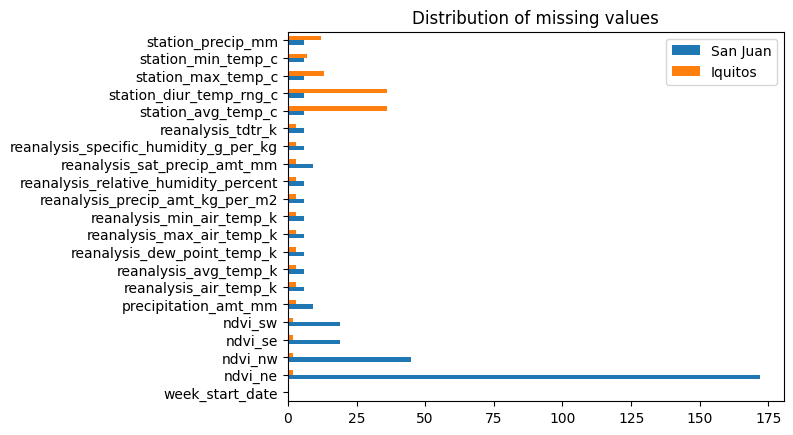

In [ ]:
## check missing values
missingDF = pd.concat([pd.isnull(sj_train_features).sum(),
                       pd.isnull(iq_train_features).sum()], axis=1).rename(columns={0:'San Juan', 1:'Iquitos'})
## Plot the distribution of missing values
plt.figure(figsize=(7, 5))
missingDF.plot.barh()
plt.title("Distribution of missing values")

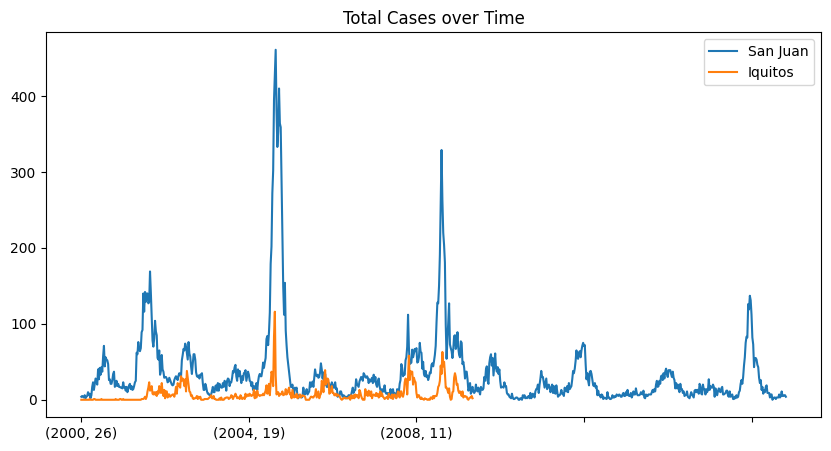

In [ ]:
## Quick look for target value
plt.figure(figsize=(10, 5))
sj_train_labels.plot(label='San Juan')
iq_train_labels.plot(label='Iquitos')

plt.title('Total Cases over Time')
plt.xlabel('')
plt.legend()

<Axes: xlabel='total_cases', ylabel='Density'>

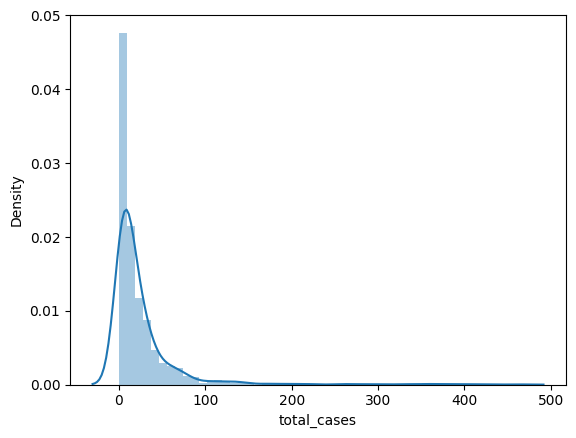

In [ ]:
## how labels distribute
sns.distplot(train_labels.total_cases)

In [ ]:
## show top 5 correlated features with target value
train_dataset = train_features.copy()
train_dataset['total_cases'] = train_labels['total_cases']
df_num_corr = train_dataset.corr()['total_cases'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr)>0].sort_values(ascending=False)[:5]
print("There is {} strongly correlated values with number of total cases:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with number of total cases:
reanalysis_min_air_temp_k    0.325252
station_min_temp_c           0.267109
reanalysis_air_temp_k        0.264952
weekofyear                   0.216452
reanalysis_avg_temp_k        0.151637
Name: total_cases, dtype: float64


#### San Juan

array([[<Axes: title={'center': 'ndvi_ne'}>,
        <Axes: title={'center': 'ndvi_nw'}>,
        <Axes: title={'center': 'ndvi_se'}>,
        <Axes: title={'center': 'ndvi_sw'}>],
       [<Axes: title={'center': 'precipitation_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_avg_temp_k'}>,
        <Axes: title={'center': 'reanalysis_dew_point_temp_k'}>],
       [<Axes: title={'center': 'reanalysis_max_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_min_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_precip_amt_kg_per_m2'}>,
        <Axes: title={'center': 'reanalysis_relative_humidity_percent'}>],
       [<Axes: title={'center': 'reanalysis_sat_precip_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_specific_humidity_g_per_kg'}>,
        <Axes: title={'center': 'reanalysis_tdtr_k'}>,
        <Axes: title={'center': 'station_avg_temp_c'}>],
       [<Axes: title={'center': 'station_diur_temp_rng

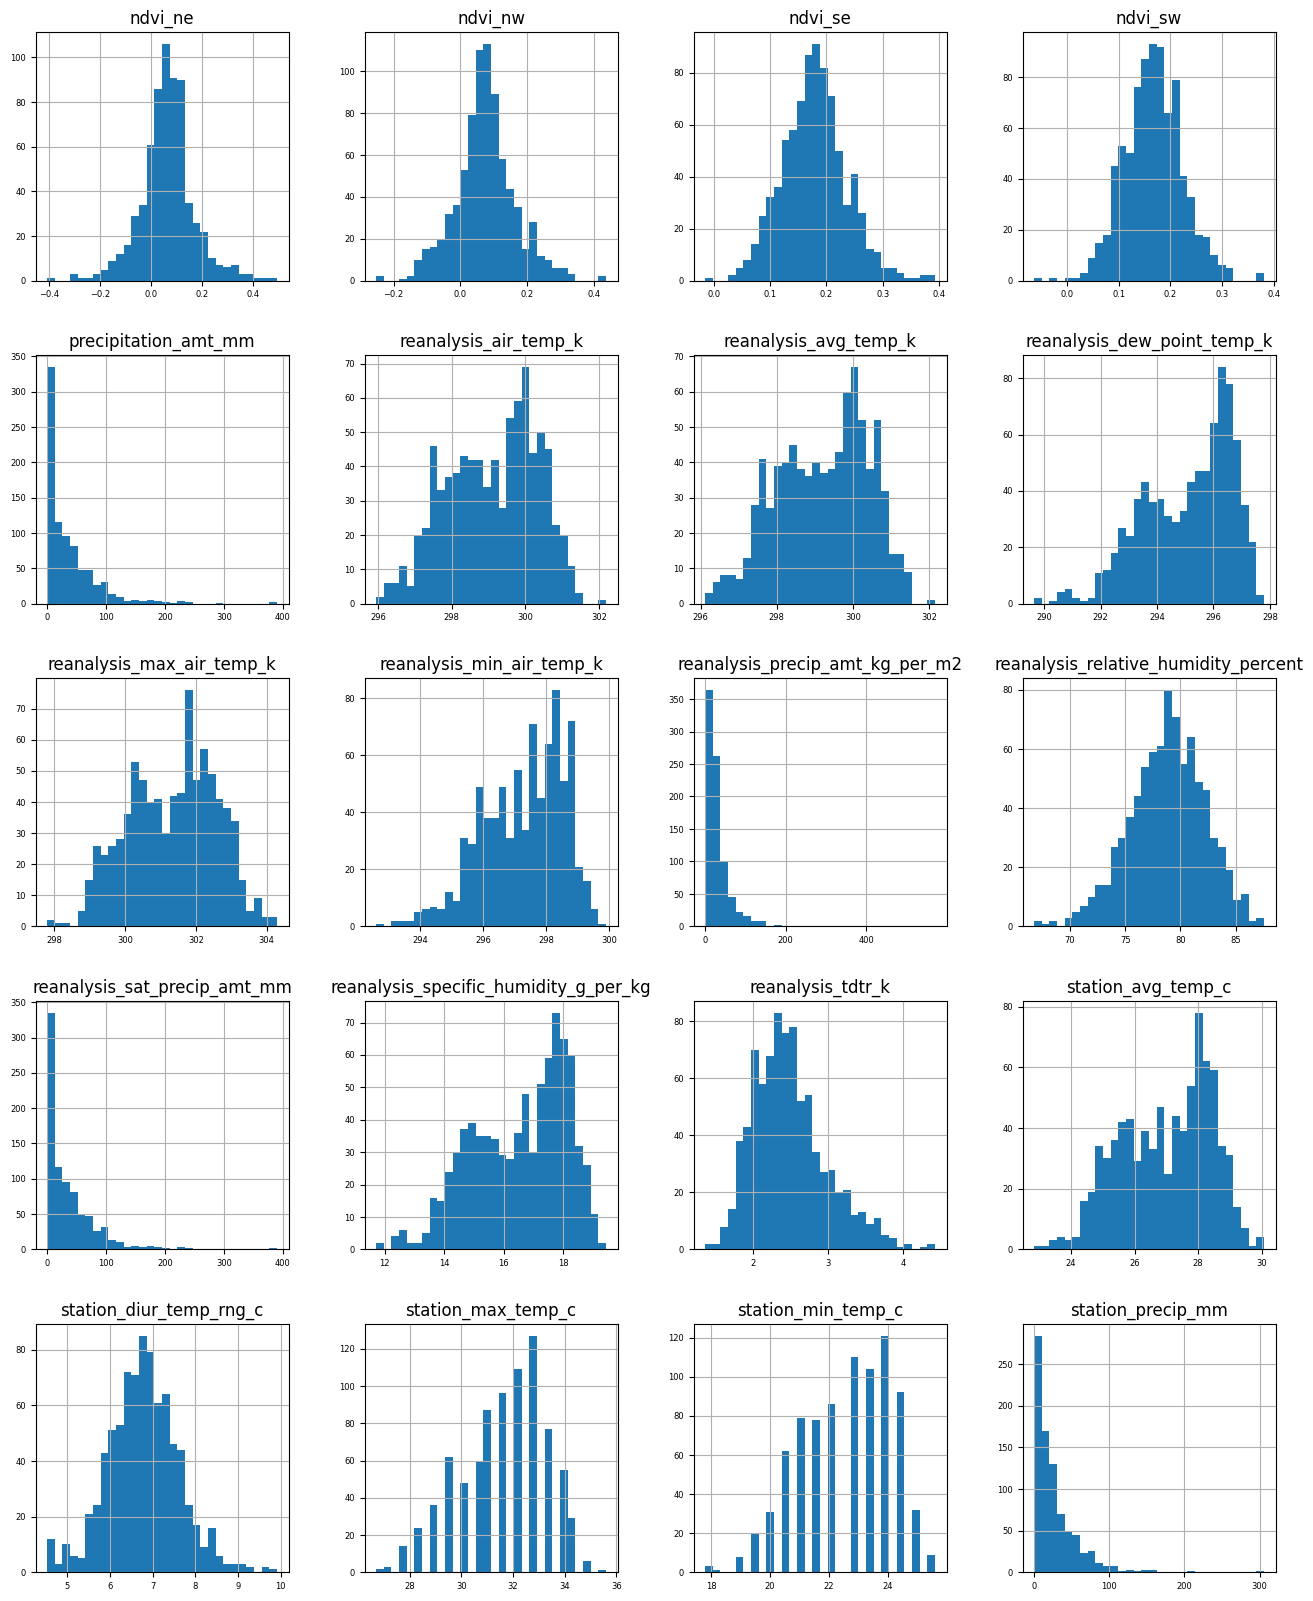

In [ ]:
## distribution of each feature
sj_train_features.hist(figsize=(16, 20), bins=30, xlabelsize=6, ylabelsize=6)

Text(0.5, 1.0, 'San Juan Variable Correlations')

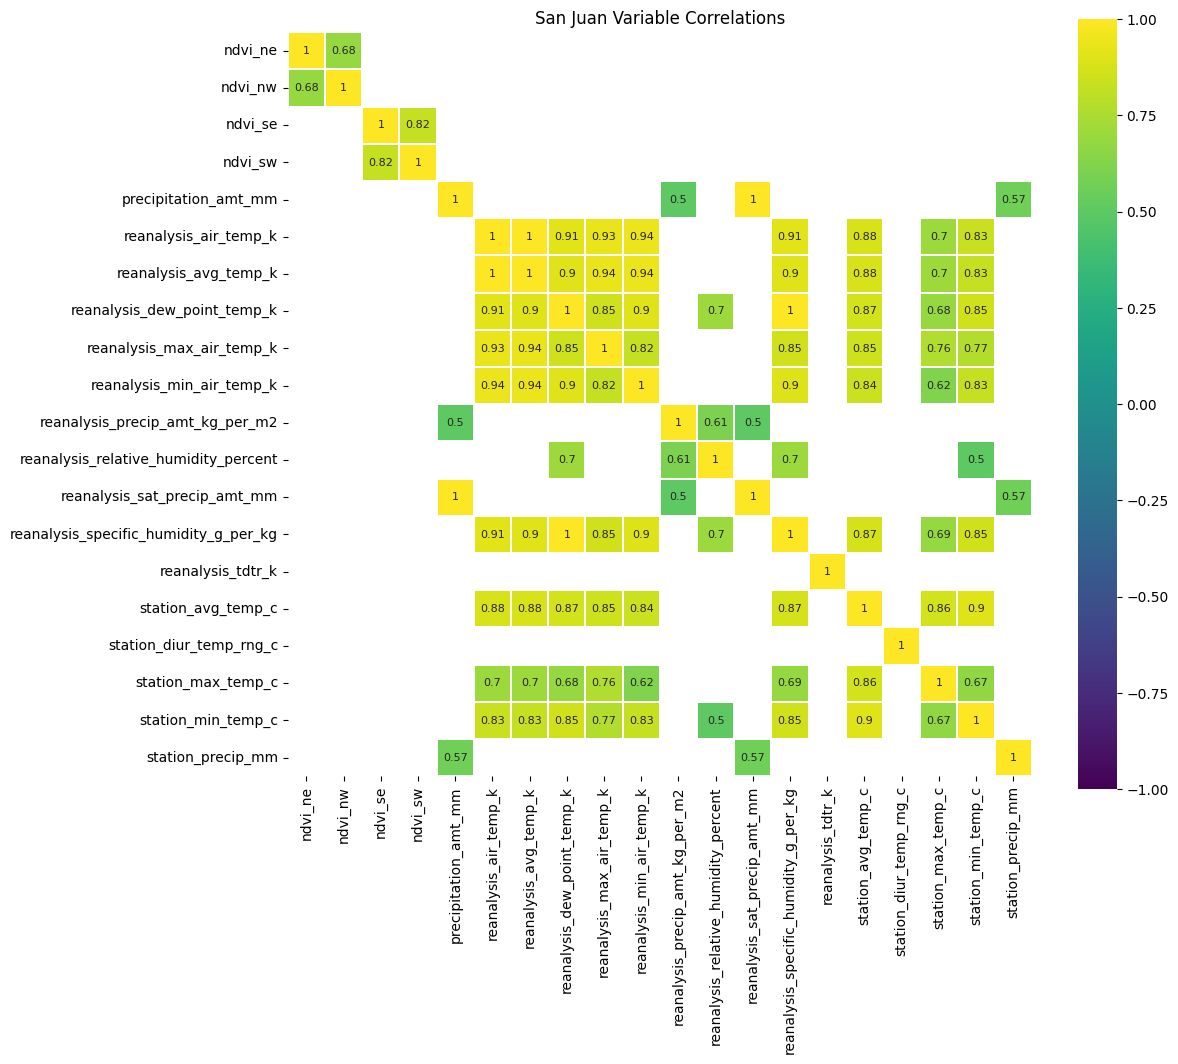

In [ ]:
## correlation between features
corr = sj_train_features.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title('San Juan Variable Correlations')

#### Iquitos

array([[<Axes: title={'center': 'ndvi_ne'}>,
        <Axes: title={'center': 'ndvi_nw'}>,
        <Axes: title={'center': 'ndvi_se'}>,
        <Axes: title={'center': 'ndvi_sw'}>],
       [<Axes: title={'center': 'precipitation_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_avg_temp_k'}>,
        <Axes: title={'center': 'reanalysis_dew_point_temp_k'}>],
       [<Axes: title={'center': 'reanalysis_max_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_min_air_temp_k'}>,
        <Axes: title={'center': 'reanalysis_precip_amt_kg_per_m2'}>,
        <Axes: title={'center': 'reanalysis_relative_humidity_percent'}>],
       [<Axes: title={'center': 'reanalysis_sat_precip_amt_mm'}>,
        <Axes: title={'center': 'reanalysis_specific_humidity_g_per_kg'}>,
        <Axes: title={'center': 'reanalysis_tdtr_k'}>,
        <Axes: title={'center': 'station_avg_temp_c'}>],
       [<Axes: title={'center': 'station_diur_temp_rng

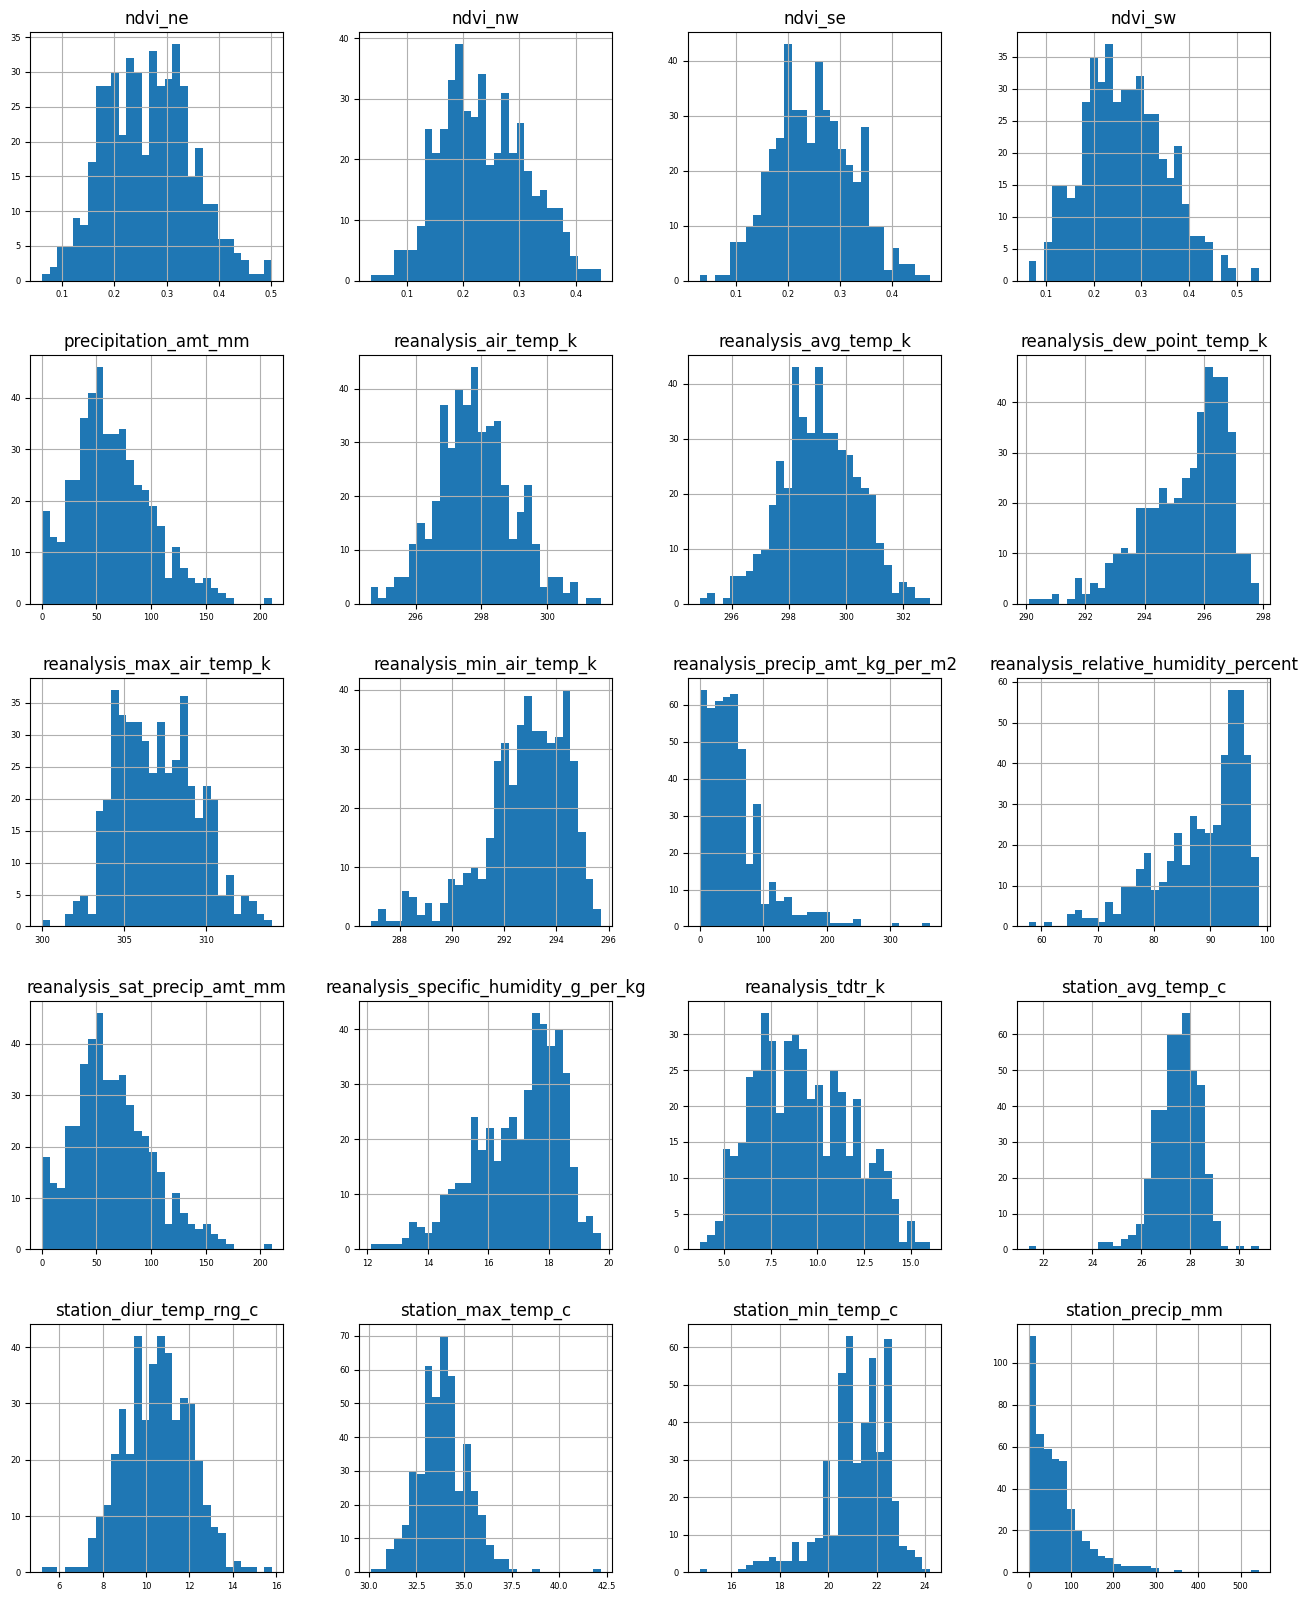

In [ ]:
## distribution of each feature
iq_train_features.hist(figsize=(16, 20), bins=30, xlabelsize=6, ylabelsize=6)

Text(0.5, 1.0, 'Iquitos Variable Correlations')

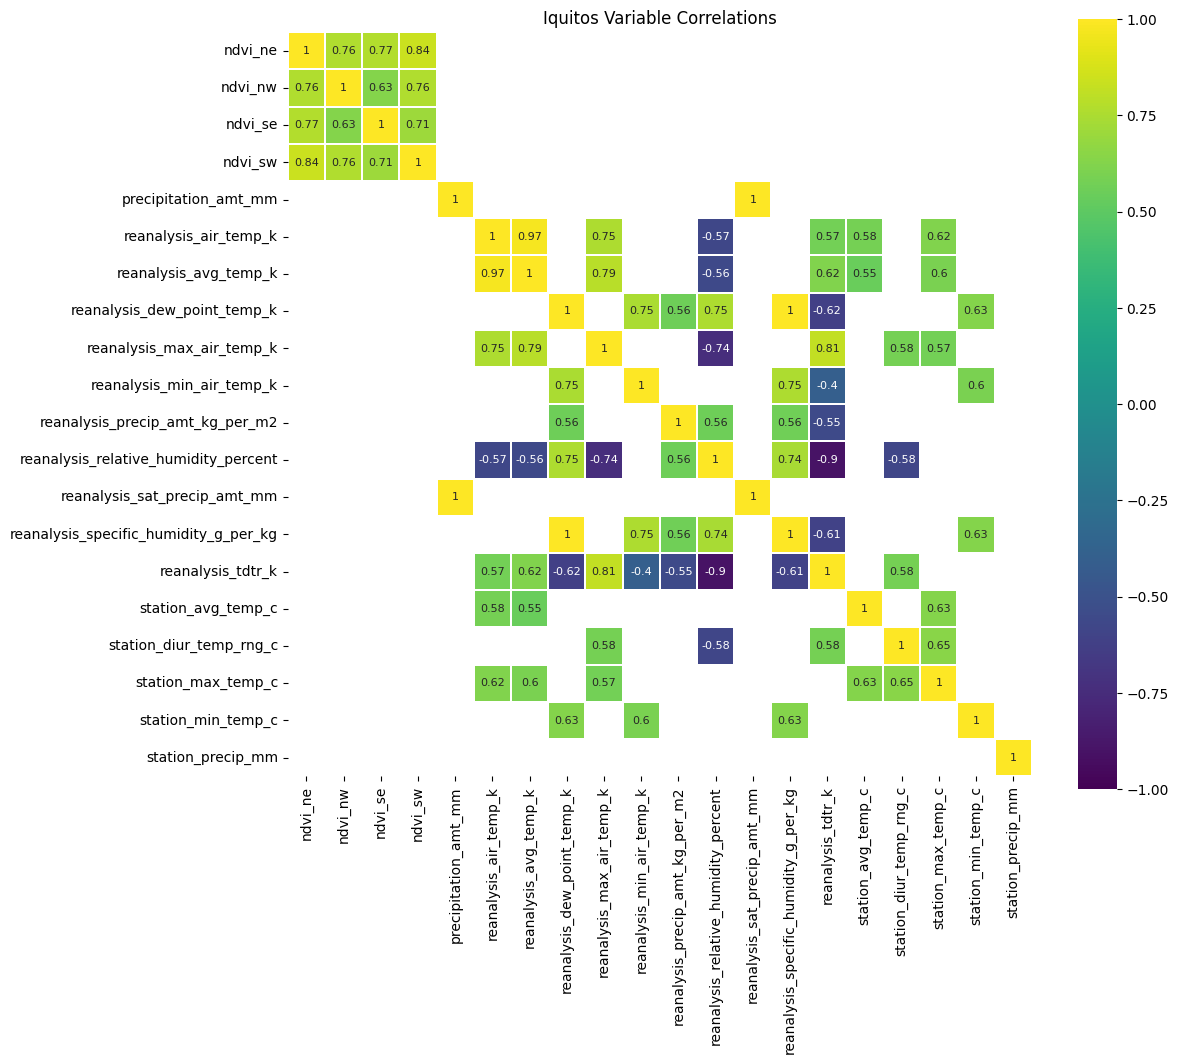

In [ ]:
## correlation between features
corr = iq_train_features.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.title('Iquitos Variable Correlations')

#### Vegetation Index Features

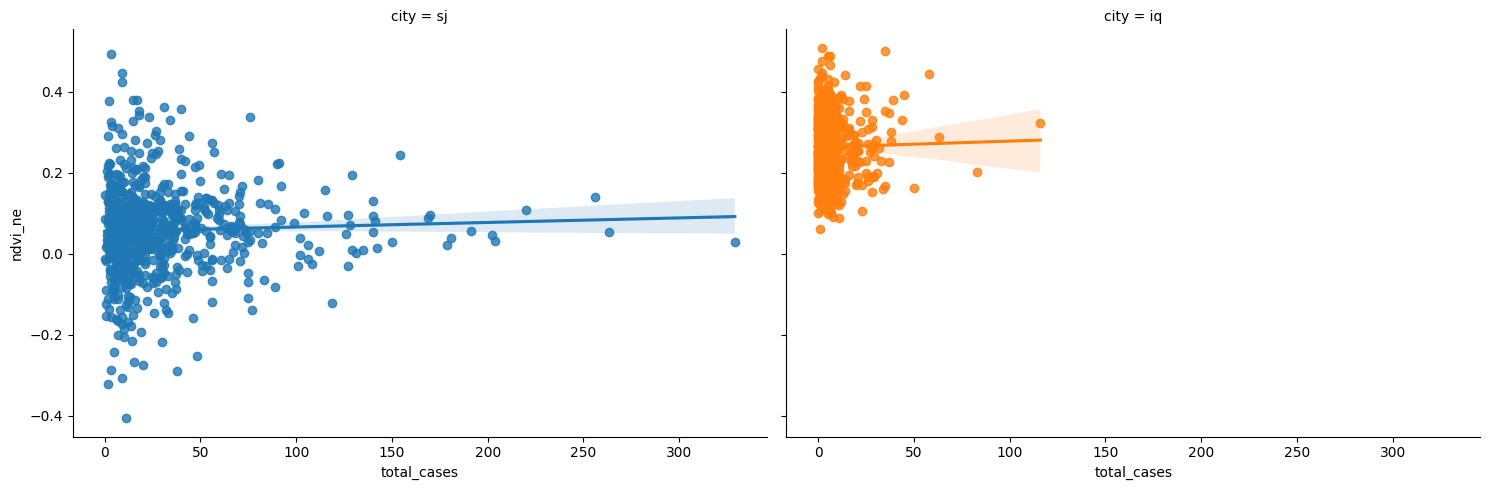

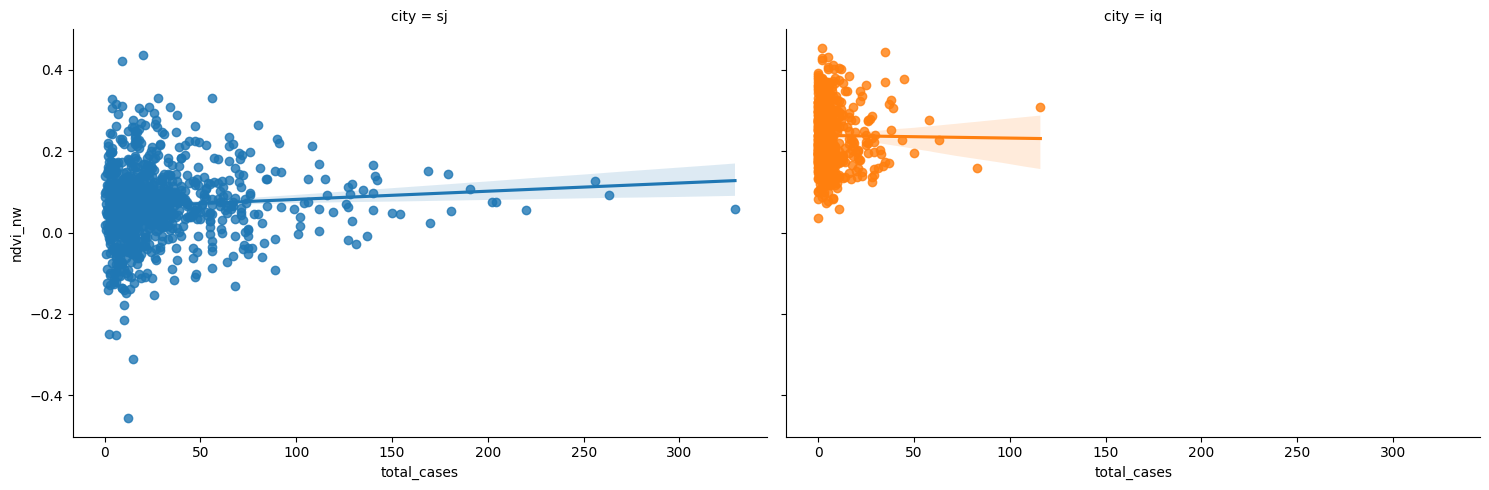

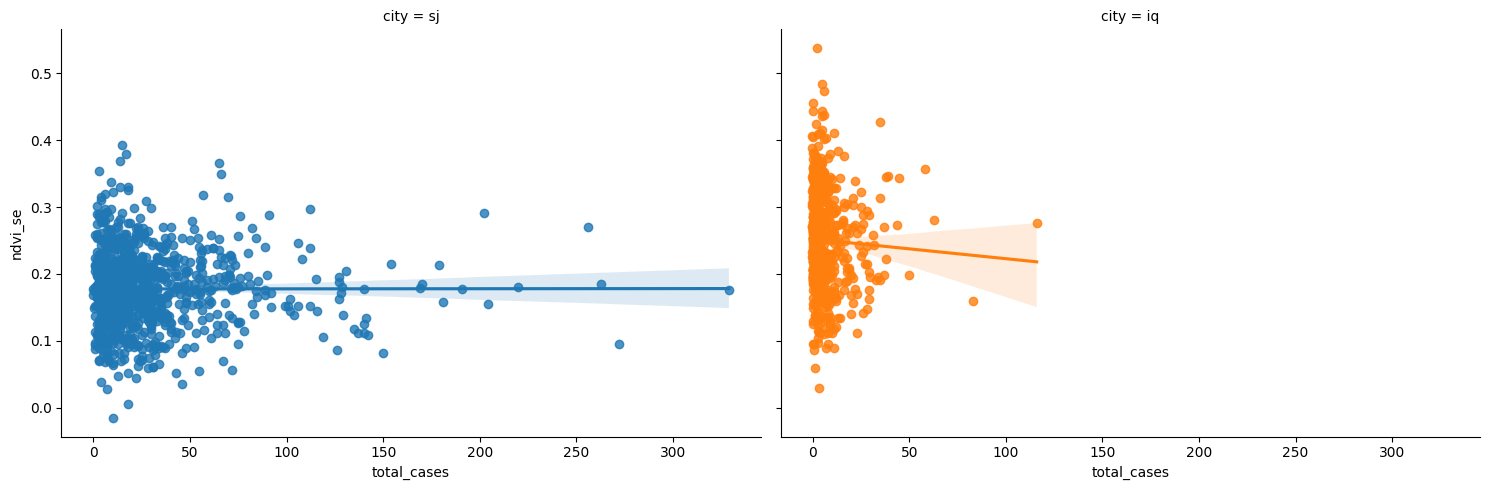

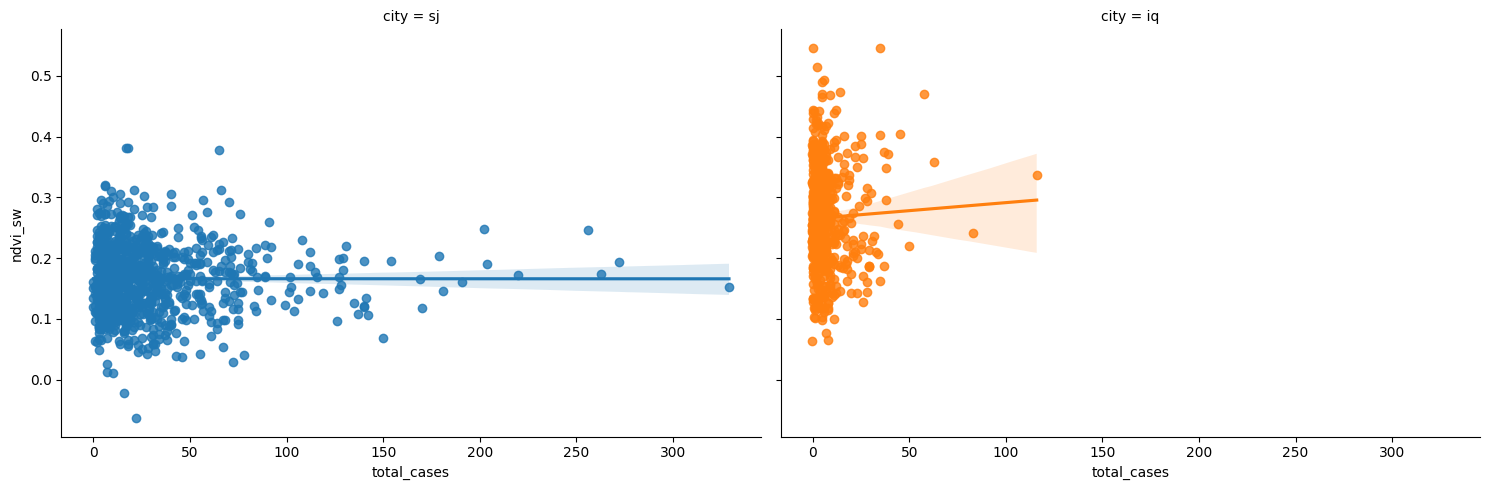

In [ ]:
## vegetation index vs total cases
sns.lmplot(x='total_cases', y='ndvi_ne', data=training_data.reset_index(), markers='o', col='city', hue='city', aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='ndvi_nw', data=training_data.reset_index(), markers='o', col='city', hue='city', aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='ndvi_se', data=training_data.reset_index(), markers='o', col='city', hue='city', aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='ndvi_sw', data=training_data.reset_index(), markers='o', col='city', hue='city', aspect=1.5, x_jitter=.1)

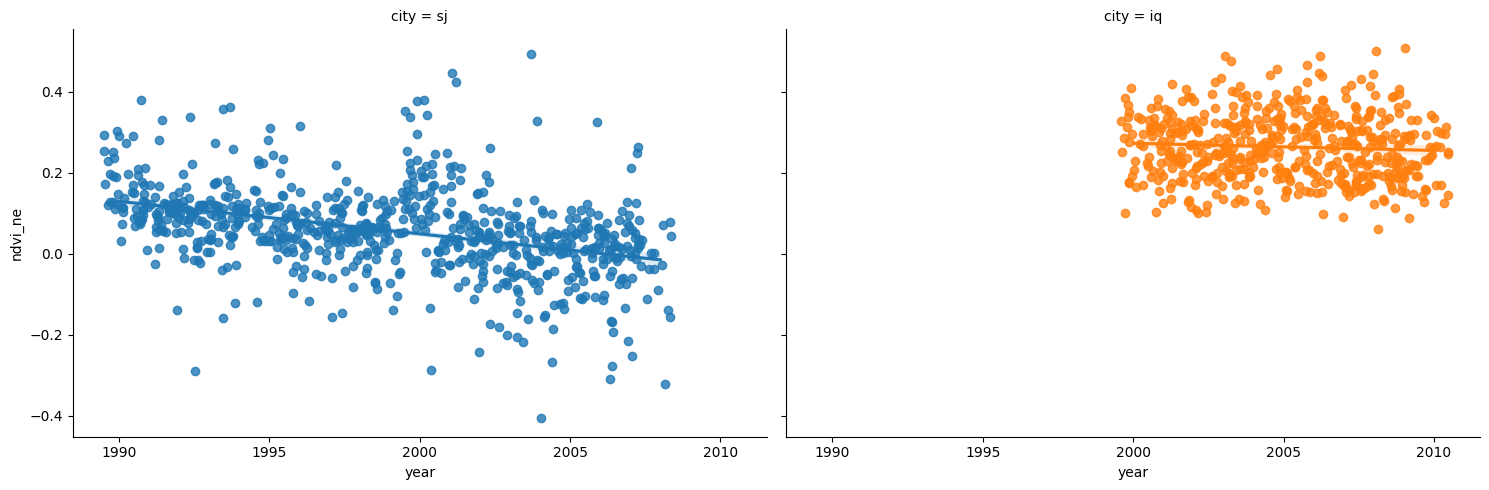

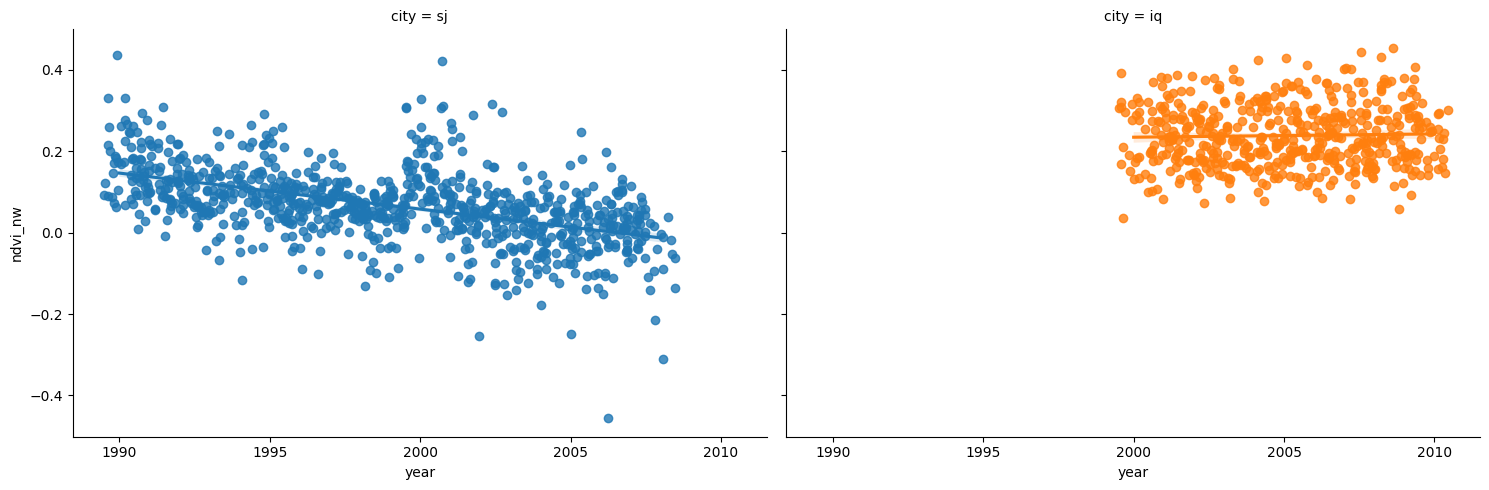

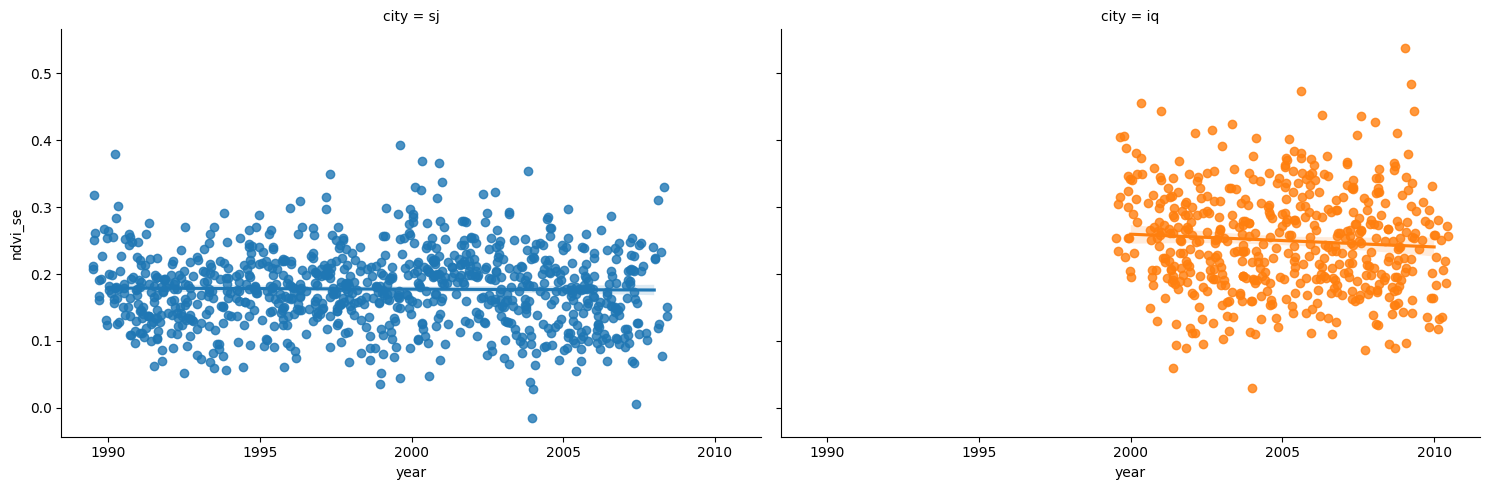

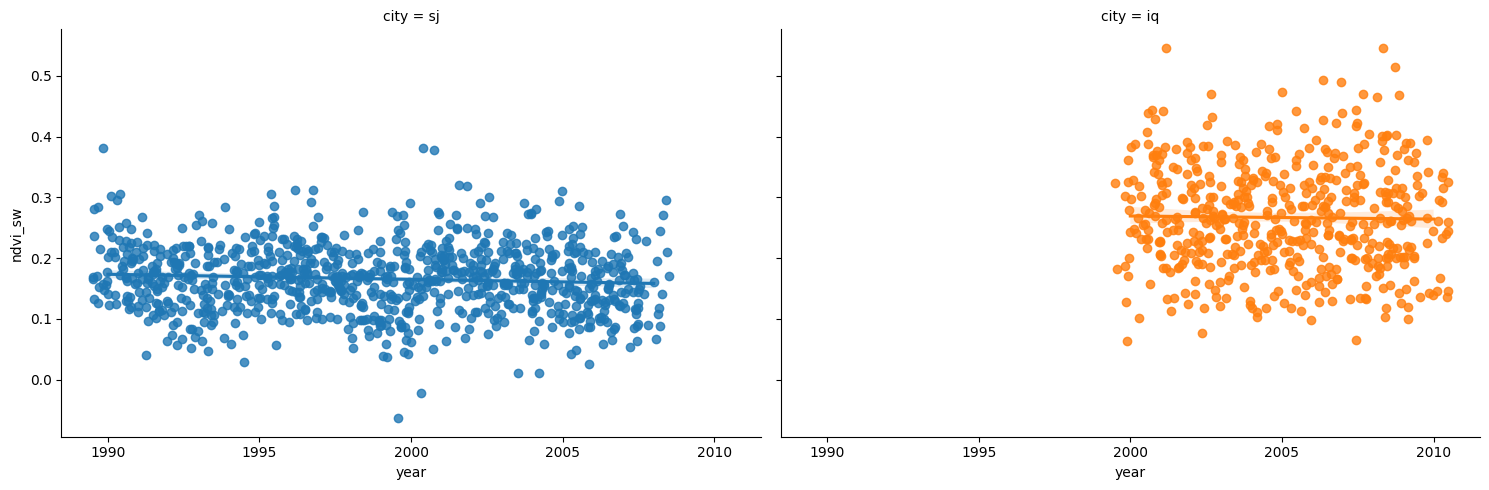

In [ ]:
## vegetation index vs year
sns.lmplot(x='year', y='ndvi_ne', data=training_data.reset_index(), markers='o', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='ndvi_nw', data=training_data.reset_index(), markers='o', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='ndvi_se', data=training_data.reset_index(), markers='o', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='ndvi_sw', data=training_data.reset_index(), markers='o', col='city', hue='city',aspect=1.5, x_jitter=.5)

#### Climate Forecast System Reanalysis

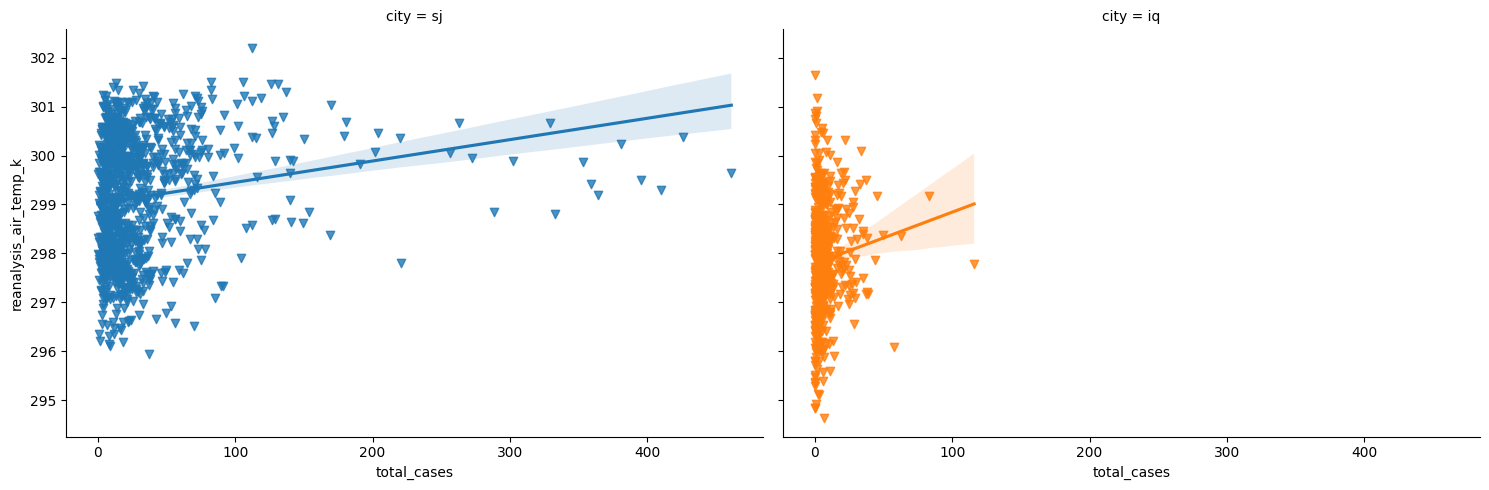

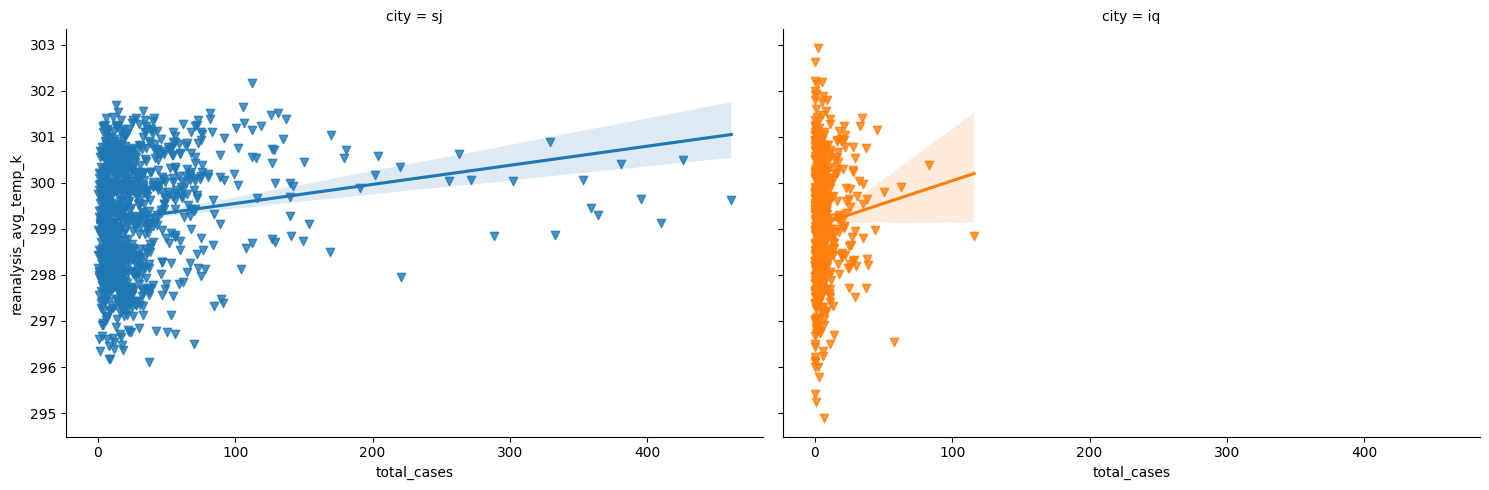

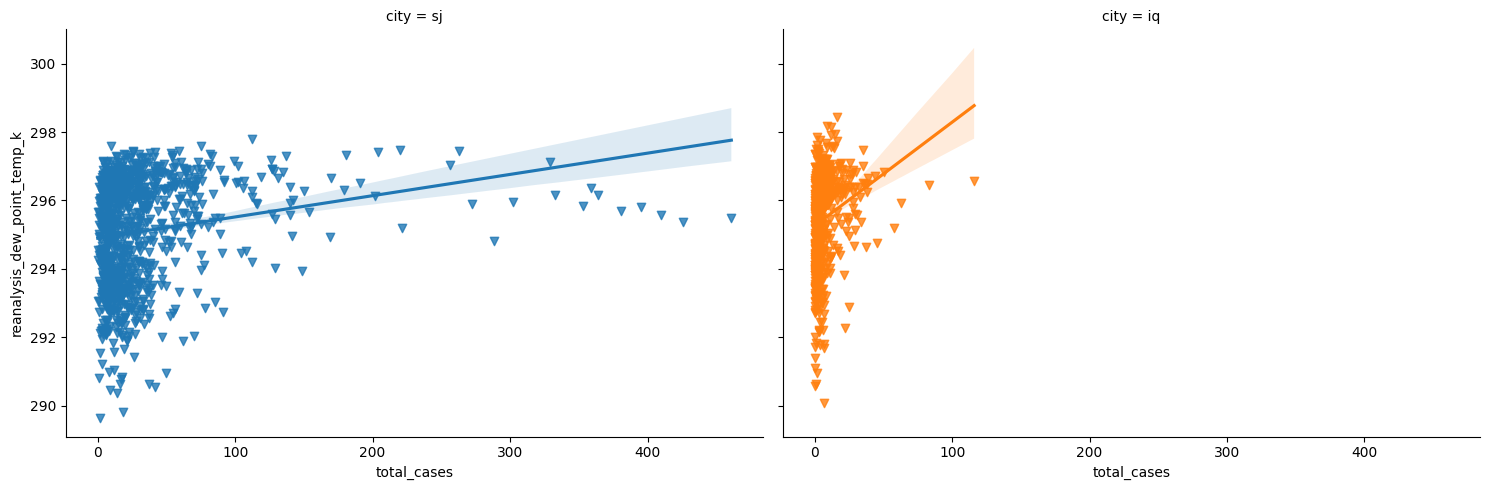

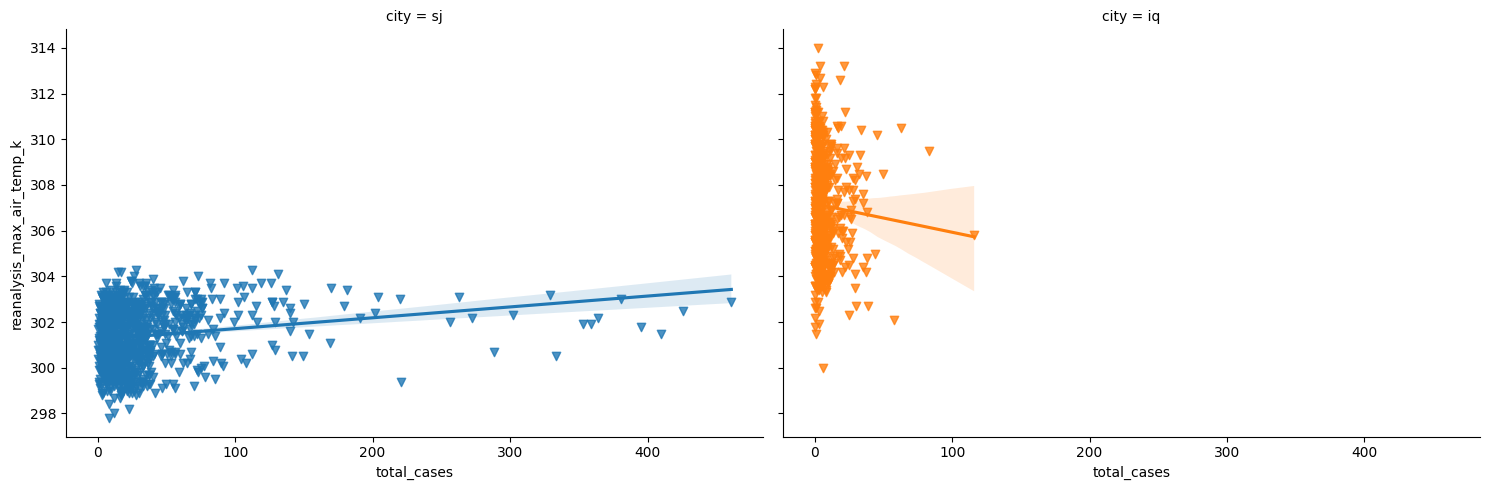

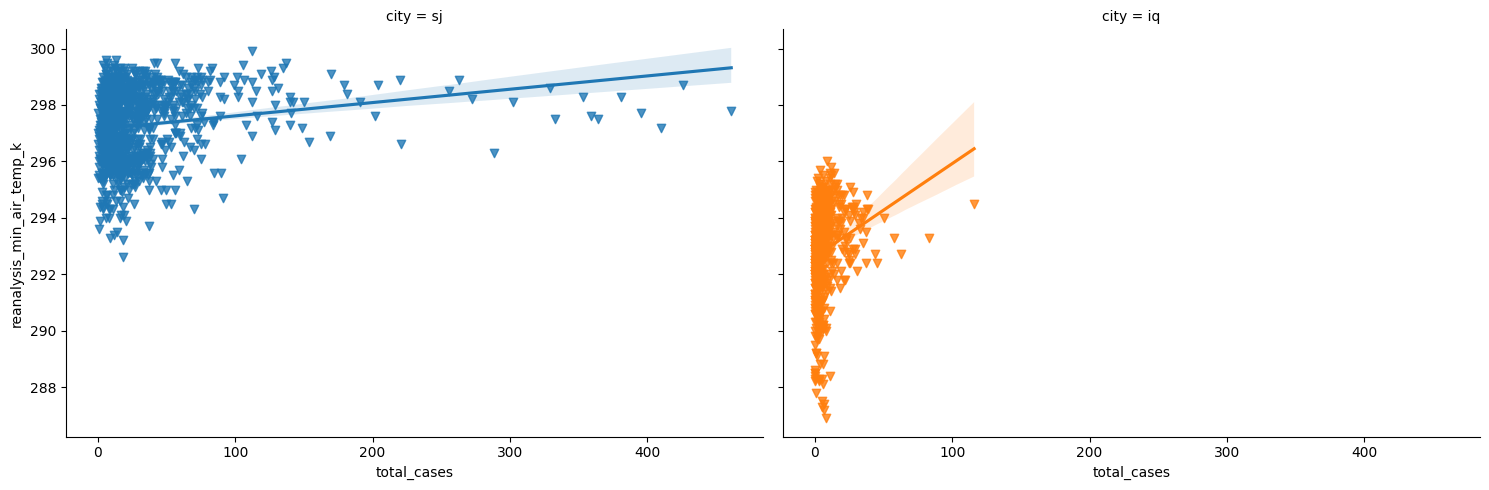

In [ ]:
## reanalysis features vs total cases
sns.lmplot(x='total_cases', y='reanalysis_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_avg_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_dew_point_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_max_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_min_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.1)

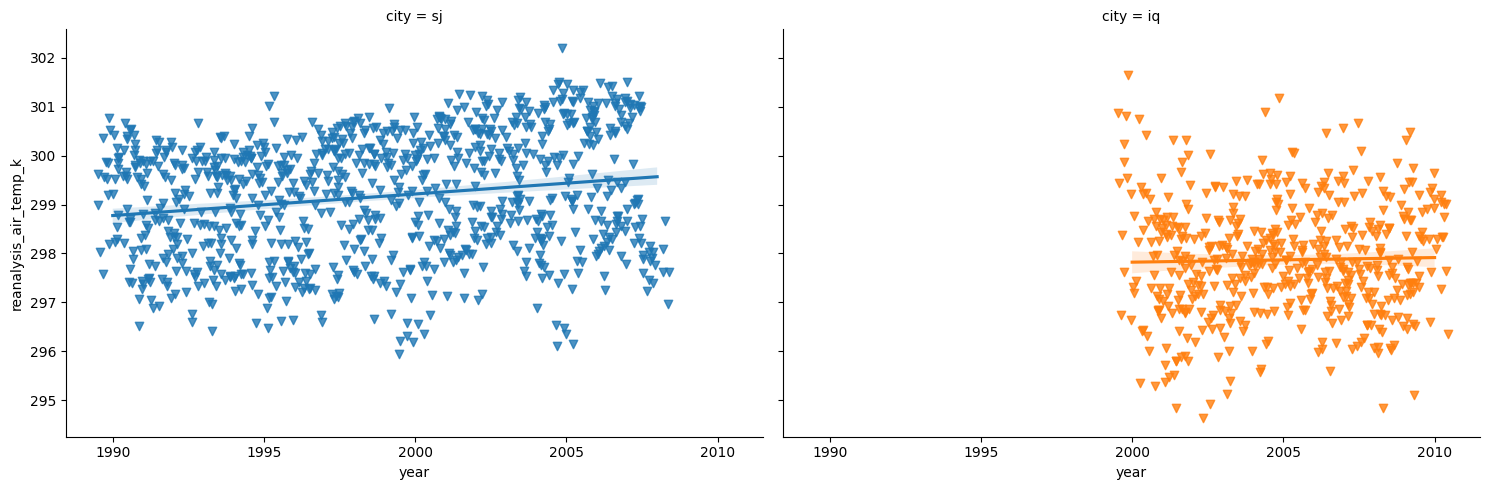

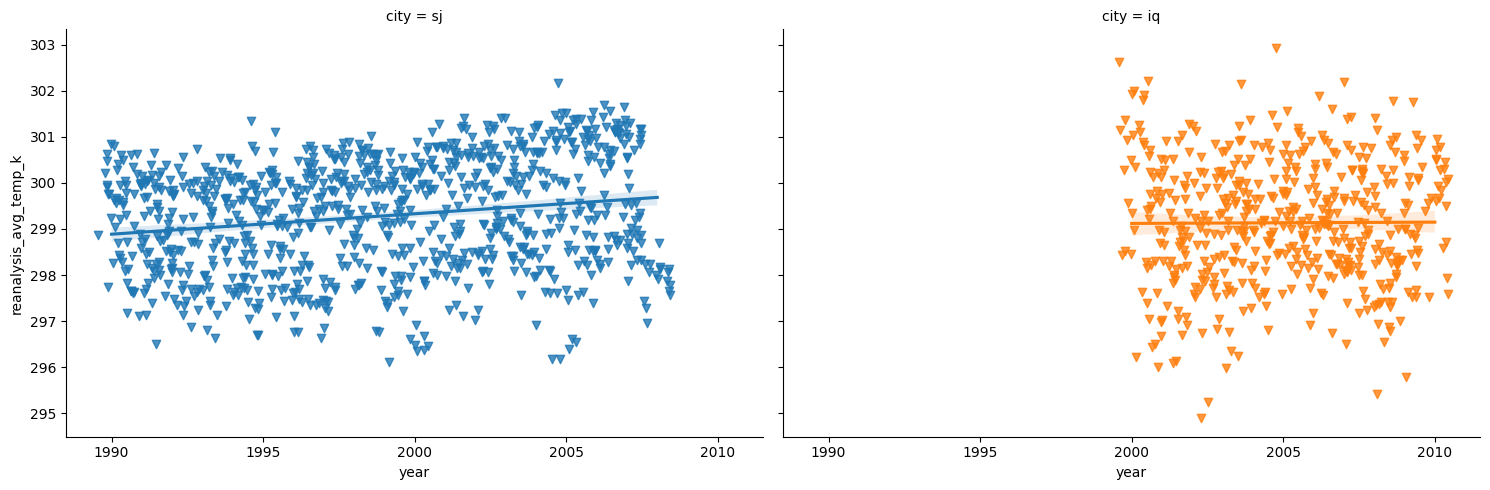

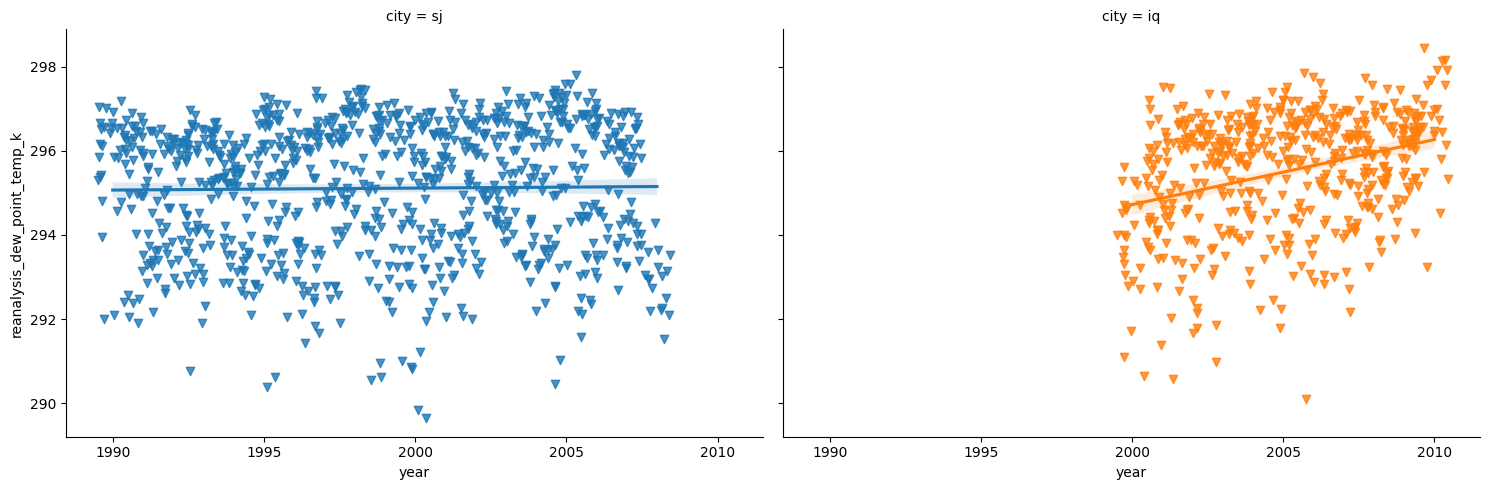

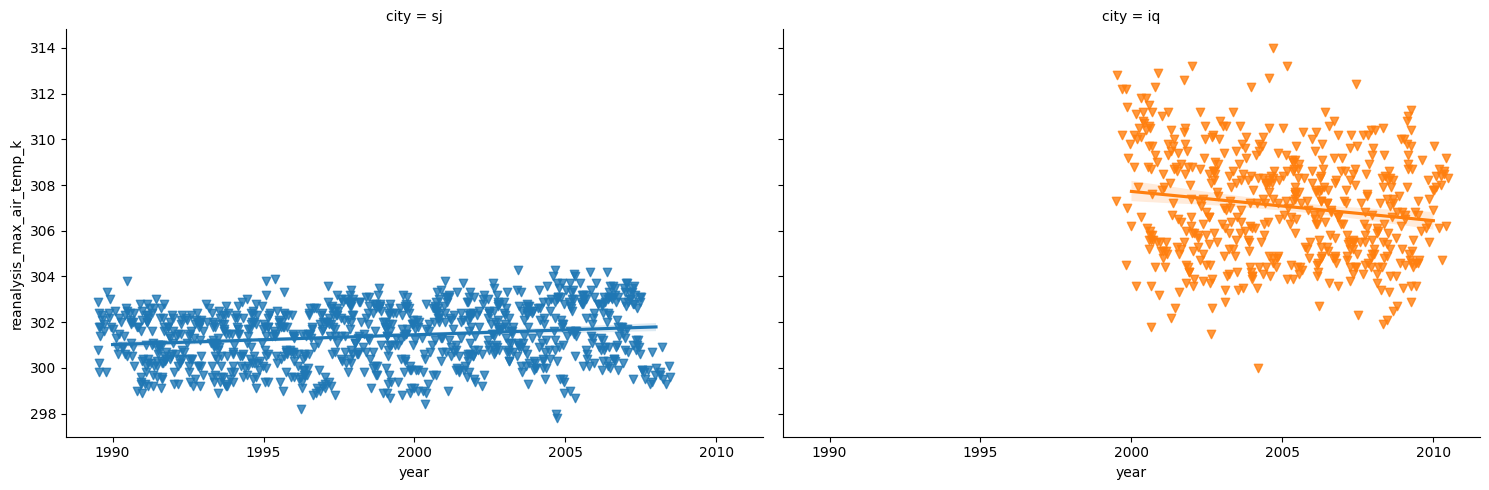

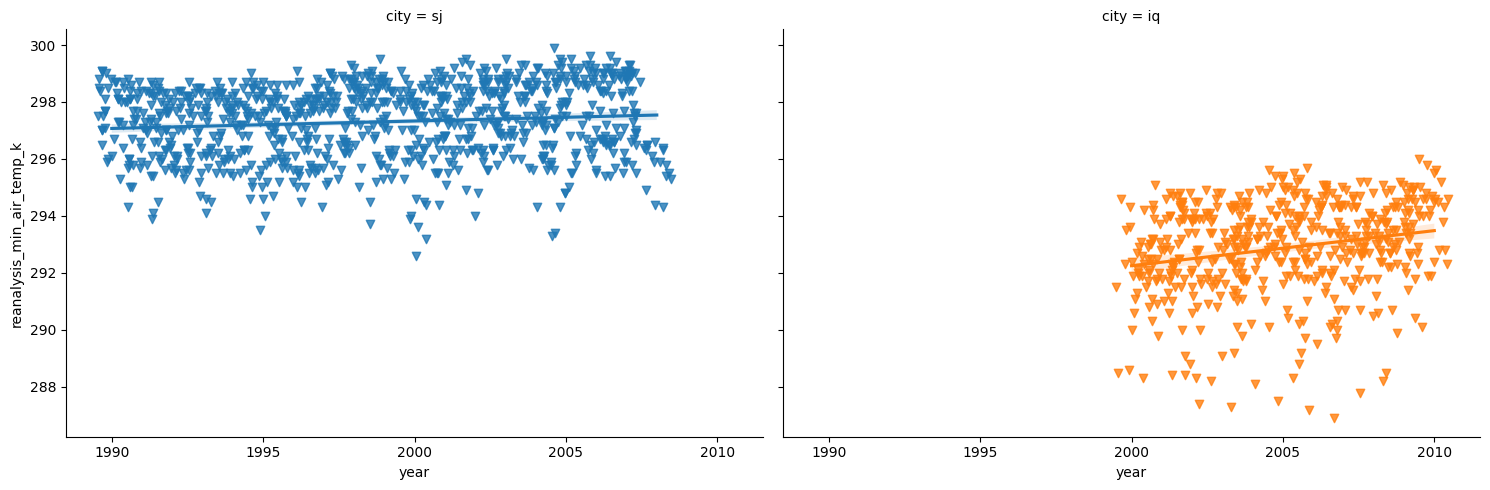

In [ ]:
## reanalysis features vs year
sns.lmplot(x='year', y='reanalysis_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_avg_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_dew_point_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_max_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_min_air_temp_k', data=training_data.reset_index(), markers='v', col='city', hue='city',aspect=1.5, x_jitter=.5)

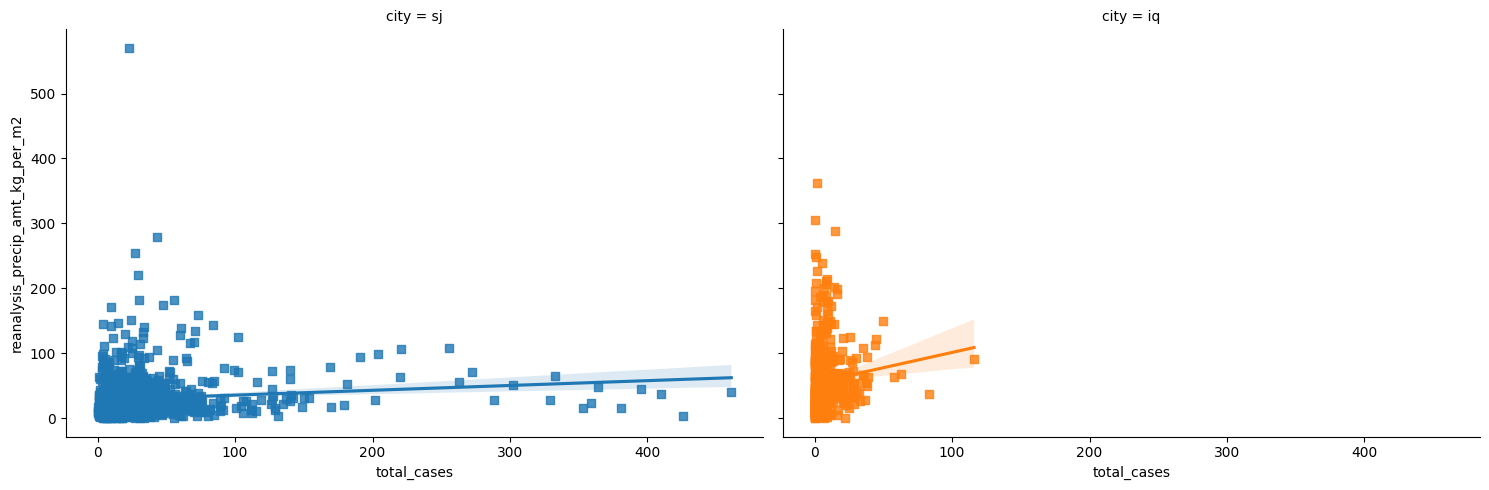

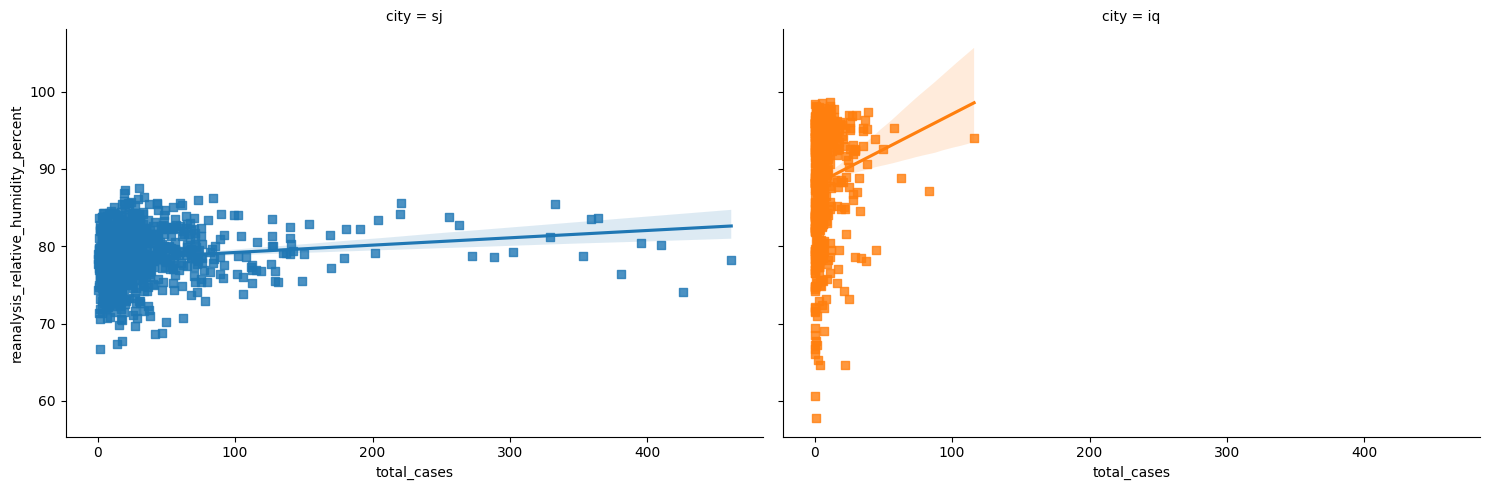

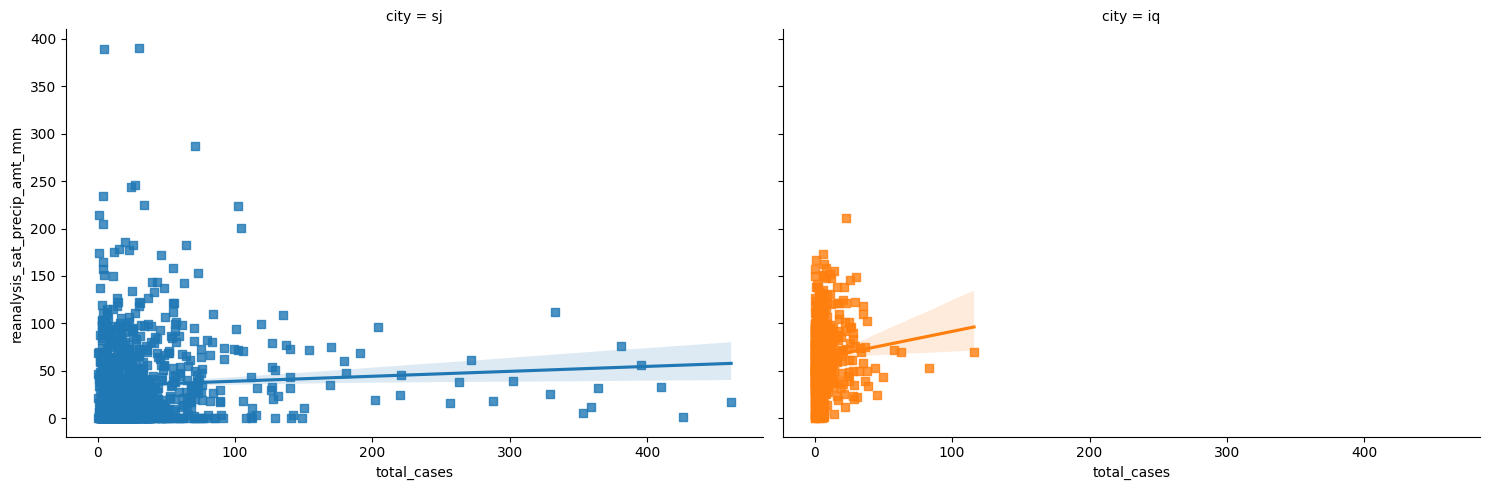

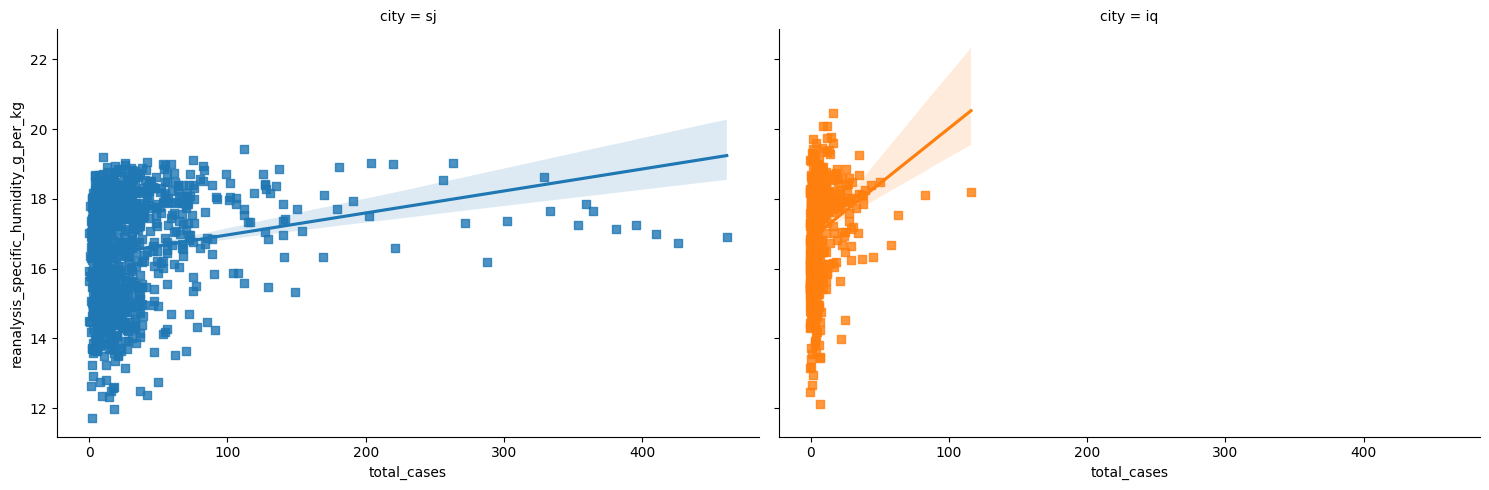

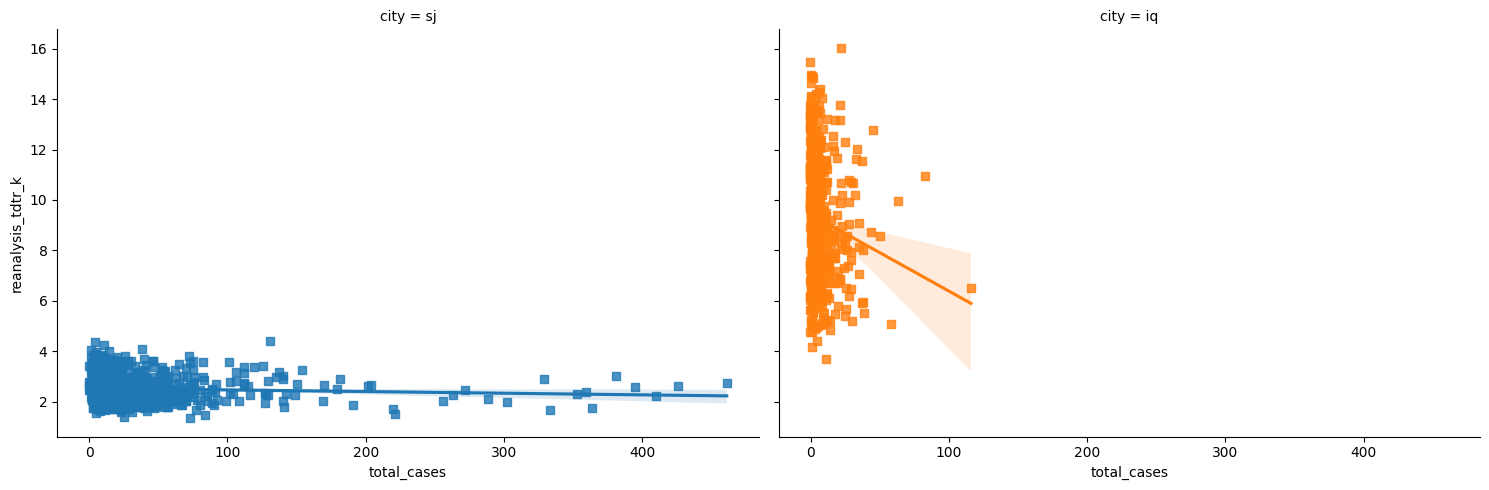

In [ ]:
## reanalysis features vs total cases
sns.lmplot(x='total_cases', y='reanalysis_precip_amt_kg_per_m2', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_relative_humidity_percent', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_sat_precip_amt_mm', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_specific_humidity_g_per_kg', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='reanalysis_tdtr_k', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.1)

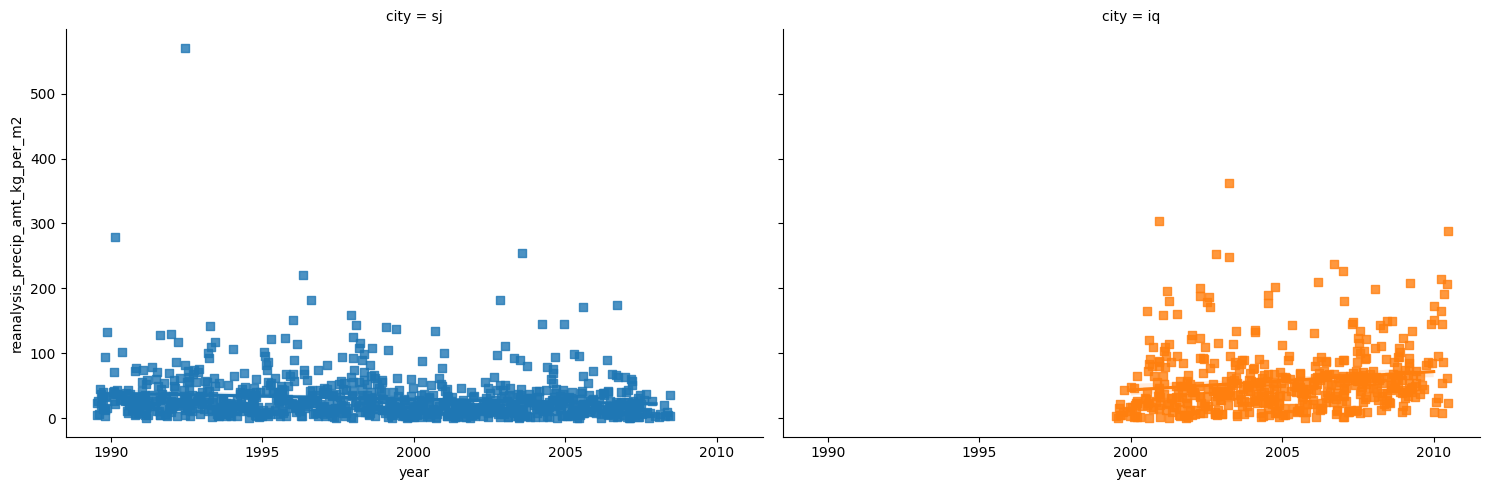

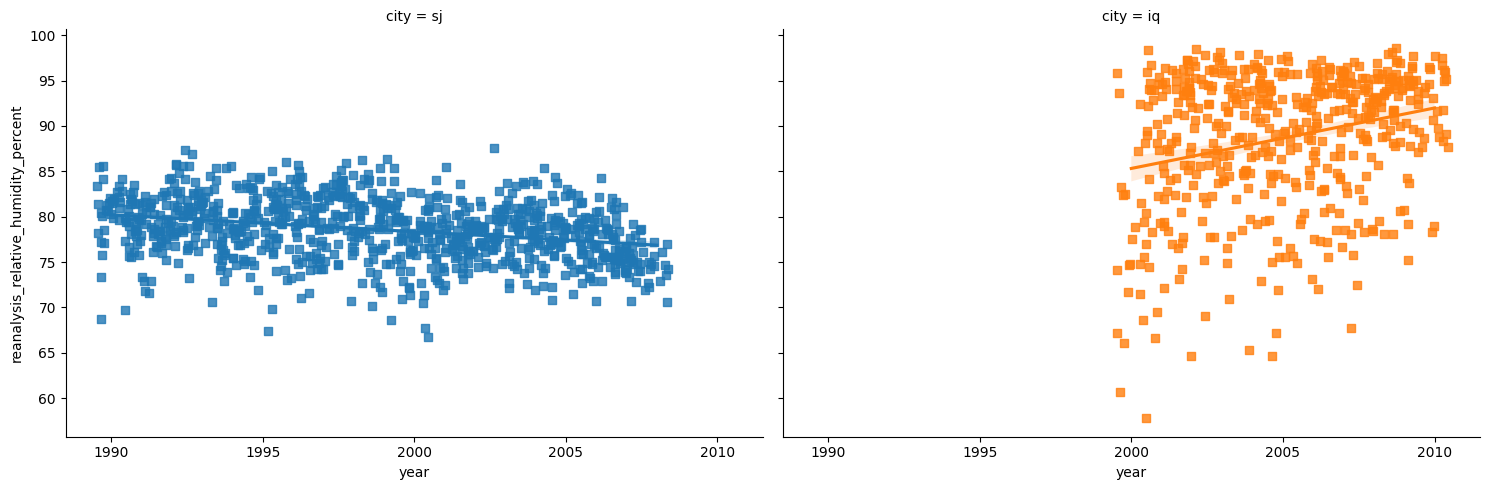

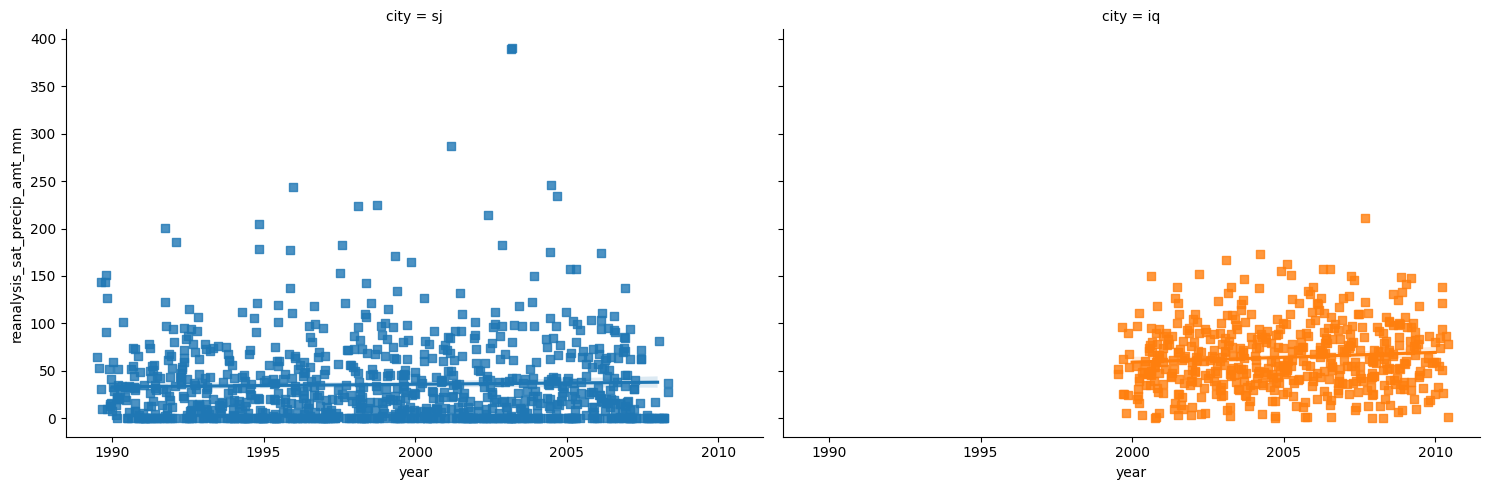

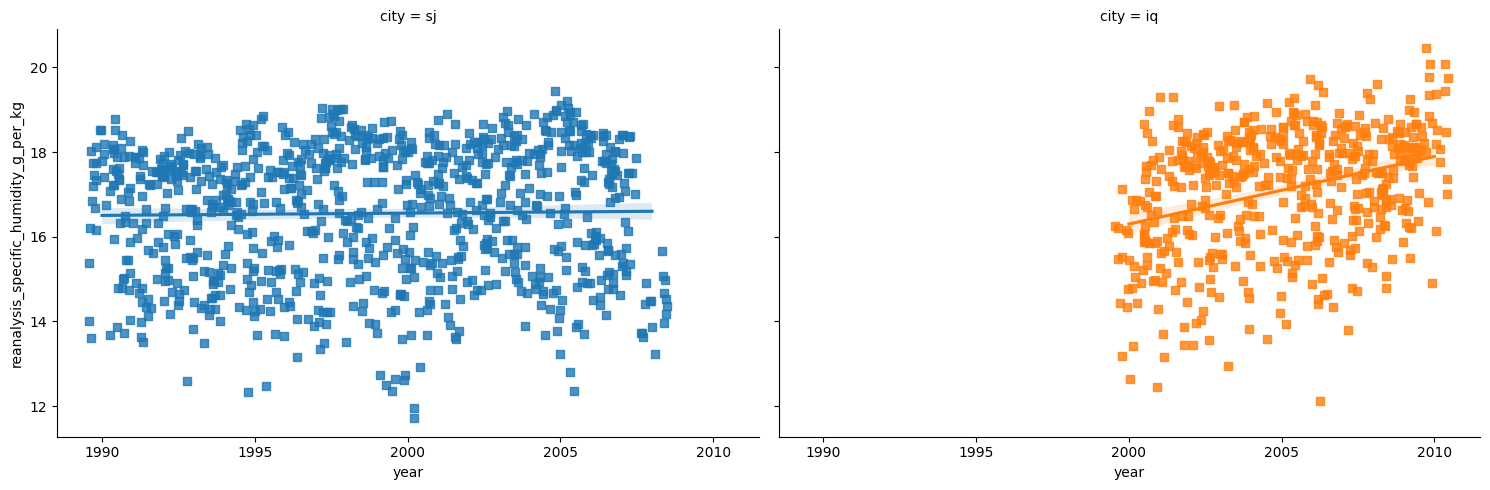

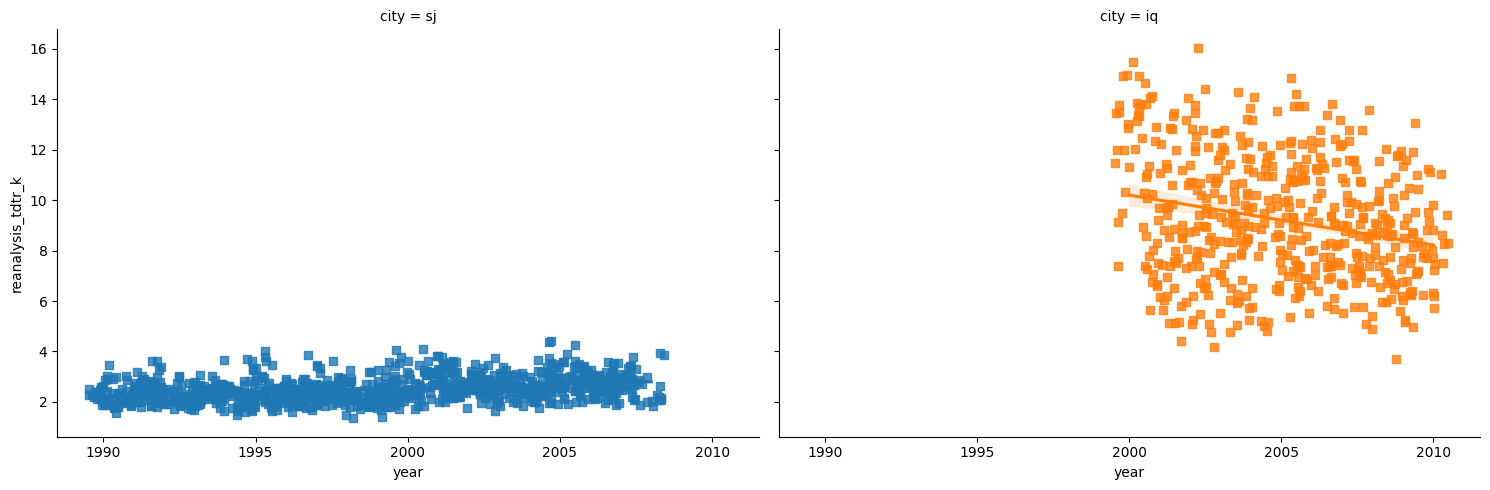

In [ ]:
## reanalysis features vs year
sns.lmplot(x='year', y='reanalysis_precip_amt_kg_per_m2', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_relative_humidity_percent', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_sat_precip_amt_mm', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_specific_humidity_g_per_kg', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='reanalysis_tdtr_k', data=training_data.reset_index(), markers='s', col='city', hue='city',aspect=1.5, x_jitter=.5)

#### Daily climate data

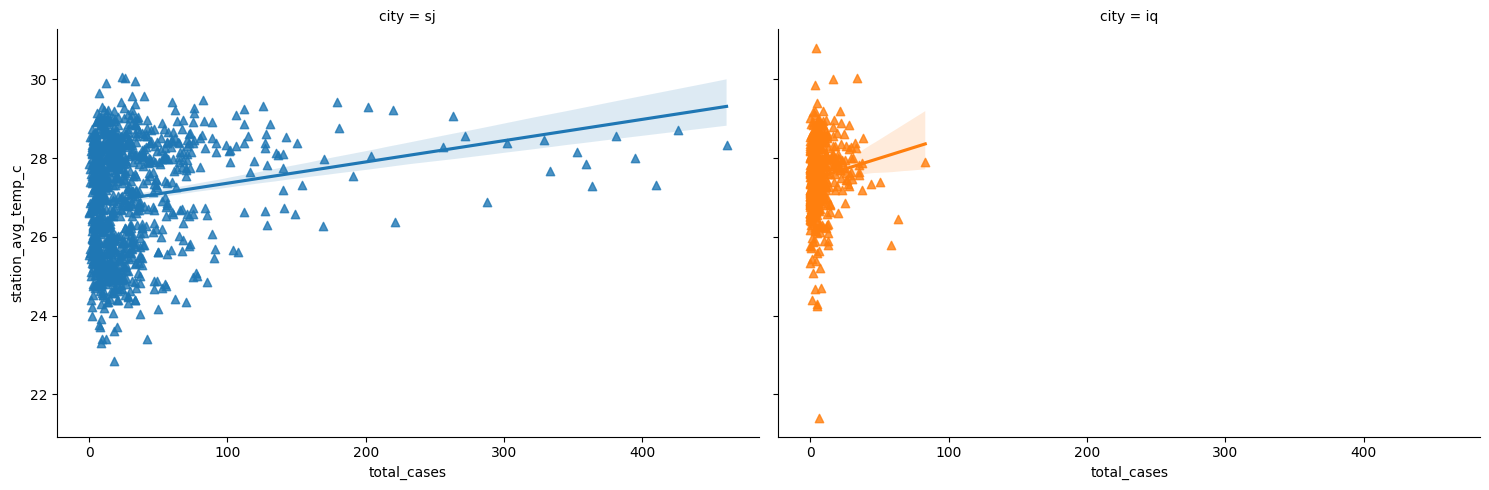

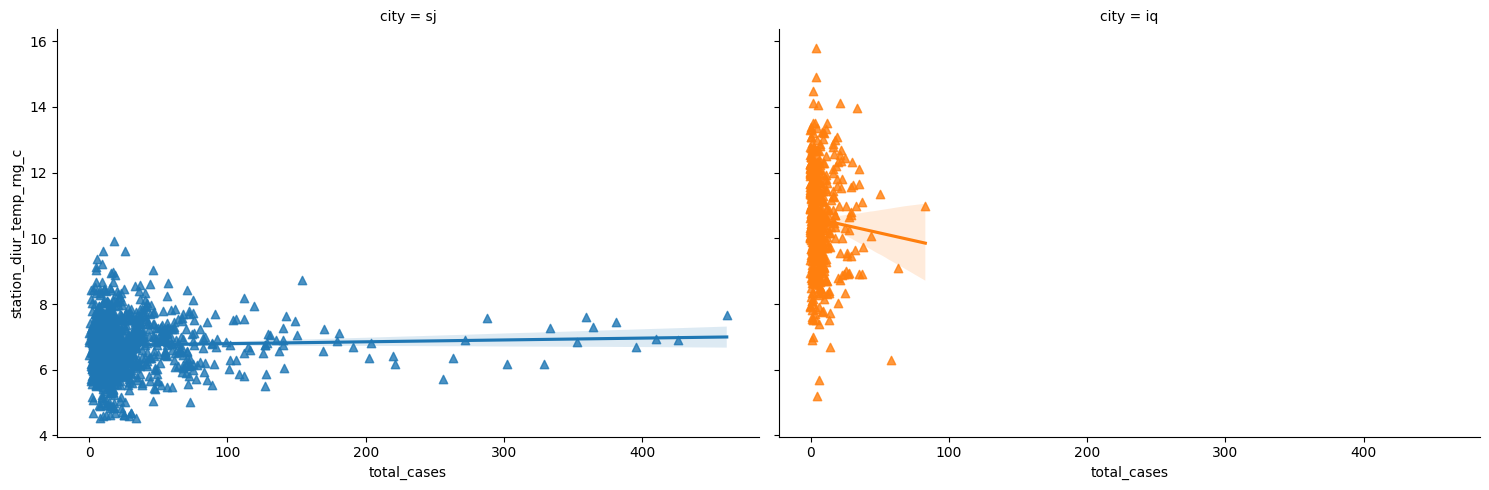

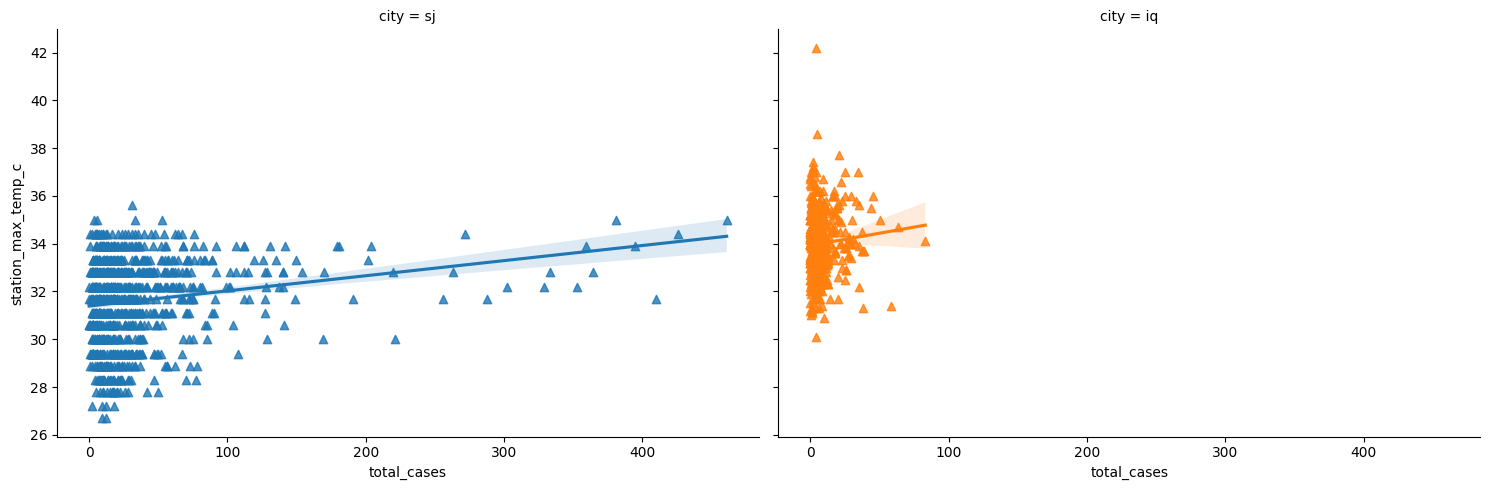

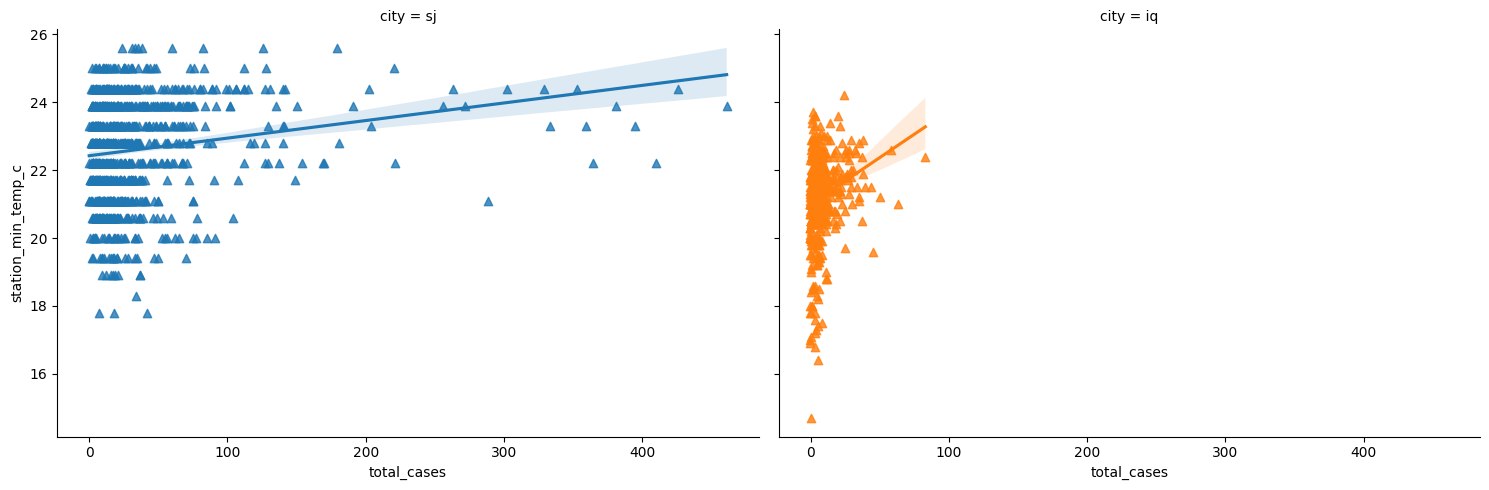

In [ ]:
## daily climate data vs total cases
sns.lmplot(x='total_cases', y='station_avg_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='station_diur_temp_rng_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='station_max_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.1)
sns.lmplot(x='total_cases', y='station_min_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.1)

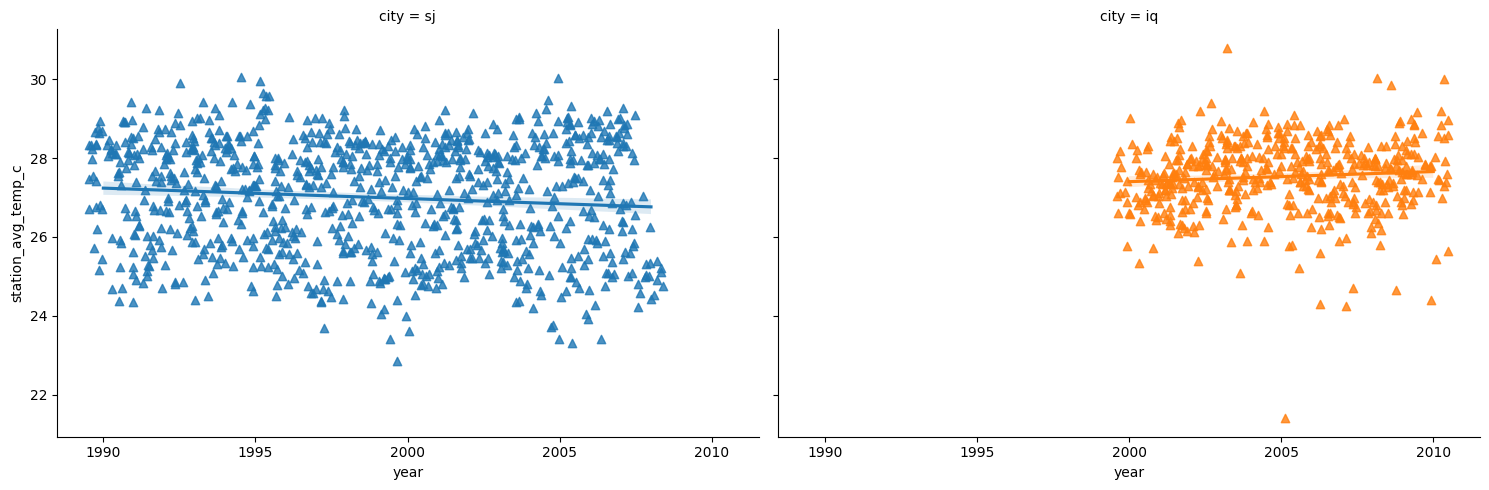

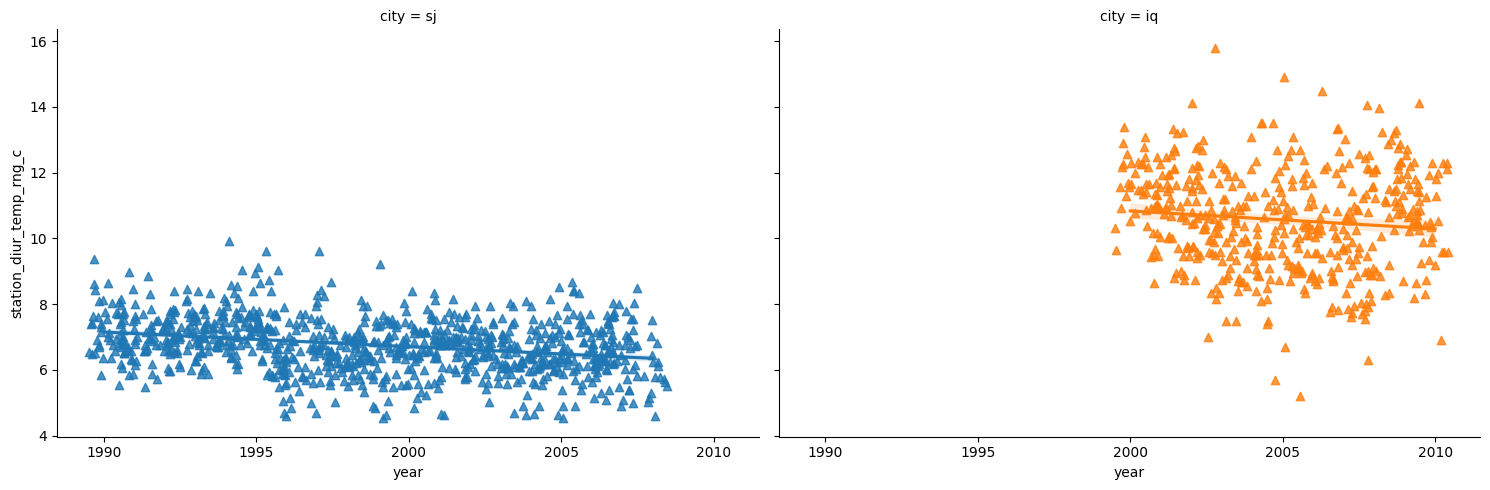

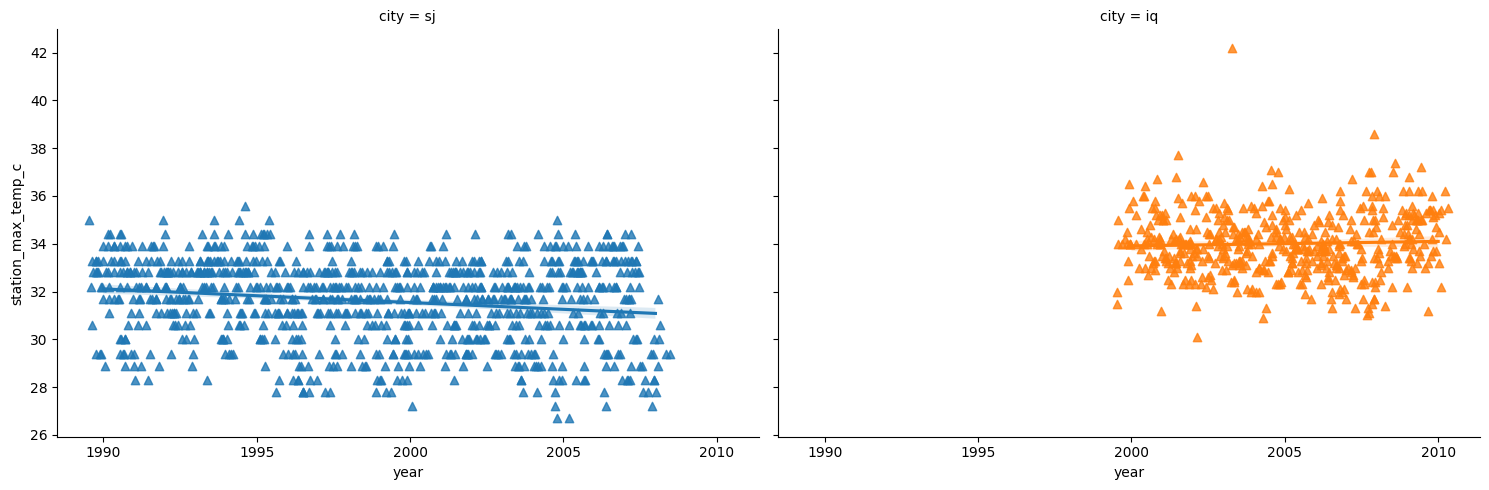

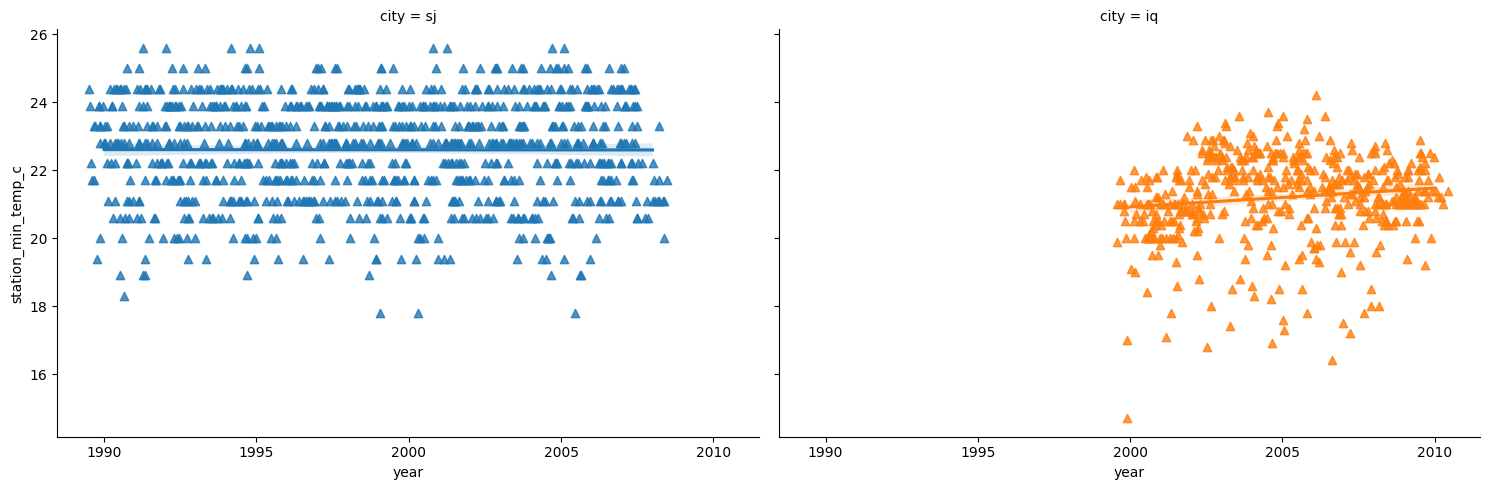

In [ ]:
## daily climate data vs year
sns.lmplot(x='year', y='station_avg_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='station_diur_temp_rng_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='station_max_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.5)
sns.lmplot(x='year', y='station_min_temp_c', data=training_data.reset_index(), markers='^', col='city', hue='city',aspect=1.5, x_jitter=.5)

#### Conlusion:
- The distribution of target value total cases are right-skewed and have some extreme values in multiple years.
- ndvi_ne has around 20% missing values (mainly for San Juan).
- Features have relativelty weak correlation with total cases. However, climate variables have much stronger correlation with each other such as reanalysis_dew_point_temp_k and reanalysis_specific_humidity_g_per_kg. More details would be discussed in feature engineer notebook.
- For each category of features, we can see that two cities have relatively different pattern for the distribution between features and target values. This means that we potentially can model two cities respectively.
- We can see few features have strong trend with time going so that the column of year could be drop in future.